## Imports

In [1]:
import pandas as pd
import numba
import numpy as np
import yfinance as yf #
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

from ta import add_all_ta_features
from ta.utils import dropna
from ta import trend
from ta import volatility
from ta import momentum

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb 

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

from arch import arch_model
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen 

import pandas_ta as ta
from pandas.tseries.offsets import BDay 
import matplotlib.dates as mdates 

import warnings
warnings.filterwarnings('ignore', category=FutureWarning, message=".*fillna with 'method' is deprecated.*")

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
# Set figure size for plots
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
ticker_symbol = "IONQ"
tickers_to_compare = ['GC=F', 'QBTS', 'GOOG', '^GSPC', 'IONQ']
start_date = '2023-03-23'

ticker = ticker_symbol
tickers = tickers_to_compare
data_period = "10y"
N_plot_days = 100 # Technical indicator plotted days

# Configuration ML forecasting
PREDICTION_TARGET = 'Close' # Predict 'Close' price or 'Log Return'
N_LAG_FEATURES = 5          # Number of past days' price/return to use as features
N_ROLLING_FEATURES = 30     # Window size for rolling mean/std features
FORECAST_HORIZON = 10       # Predict 1 day ahead
TEST_SIZE = 0.2             # Use last 20% of data for testing
LSTM_LOOKBACK = 60          # Use last 60 days of data to predict the next day for LSTM

tickers_var = ['GC=F', 'DX-Y.NYB', '^TNX']

## Functions

In [4]:
def calculate_returns(price_df):
    return price_df.pct_change(fill_method=None).dropna()

def annualized_return(returns, periods_per_year=252):
    return (1 + returns.mean()) ** periods_per_year - 1

def annualized_volatility(returns, periods_per_year=252):
    return returns.std() * np.sqrt(periods_per_year)

def sharpe_ratio(returns, risk_free_rate=0.0, periods_per_year=252):
    excess_return = returns - risk_free_rate / periods_per_year
    return (excess_return.mean() / returns.std()) * np.sqrt(periods_per_year)

def sortino_ratio(returns, risk_free_rate=0.0, periods_per_year=252):
    negative_returns = returns[returns < 0]
    downside_deviation = negative_returns.std() * np.sqrt(periods_per_year)
    excess_return = returns.mean() * periods_per_year - risk_free_rate
    return excess_return / downside_deviation if downside_deviation != 0 else np.nan

def max_drawdown(price_series):
    cum_returns = (1 + price_series.pct_change(fill_method=None)).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    return drawdown.min()

def rolling_metrics(returns, window=63):  # ~3 months
    rolling_vol = returns.rolling(window).std() * np.sqrt(252)
    rolling_sharpe = returns.rolling(window).mean() / returns.rolling(window).std() * np.sqrt(252)
    return rolling_vol, rolling_sharpe

def beta_alpha(asset_returns, benchmark_returns):
    slope, intercept, _, _, _ = linregress(benchmark_returns, asset_returns)
    return slope, intercept  # Beta, Alpha

def correlation_matrix(returns_df):
    return returns_df.corr()
    
def analyze_asset(asset_prices, benchmark_prices=None):
    results = {}
    returns = asset_prices.pct_change(fill_method=None).dropna()

    results['Annualized Return'] = annualized_return(returns)
    results['Annualized Volatility'] = annualized_volatility(returns)
    results['Sharpe Ratio'] = sharpe_ratio(returns)
    results['Sortino Ratio'] = sortino_ratio(returns)
    results['Max Drawdown'] = max_drawdown(asset_prices)

    if benchmark_prices is not None:
        benchmark_returns = benchmark_prices.pct_change(fill_method=None).dropna()
        aligned = pd.concat([returns, benchmark_returns], axis=1).dropna()
        beta, alpha = beta_alpha(aligned.iloc[:, 0], aligned.iloc[:, 1])
        results['Beta vs Benchmark'] = beta
        results['Alpha vs Benchmark'] = alpha

    return results

def get_fundamentals(ticker):
    stock = yf.Ticker(ticker)
    info = stock.info

    return {
        'Ticker': ticker,
        'P/E Ratio': info.get('trailingPE', None),
        'Forward P/E': info.get('forwardPE', None),
        'EV/EBITDA': info.get('enterpriseToEbitda', None),
        'Profit Margin': info.get('profitMargins', None),
        'Return on Equity': info.get('returnOnEquity', None),
    }

def merge_fundamentals_with_metrics(metrics_df, fundamentals):
    fundamentals_df = pd.DataFrame([fundamentals] * len(metrics_df), 
                                   index=metrics_df.index)
    combined_df = pd.concat([metrics_df, fundamentals_df], axis=1)
    return combined_df


## Implementation

In [5]:
gold_data = yf.Ticker(ticker_symbol)
hist_df = gold_data.history(period=data_period)
gold_price = hist_df[['Close']].copy()

In [6]:
price_data = yf.download(tickers, start=start_date)['Close']

[**********************60%****                   ]  3 of 5 completed

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


In [7]:
gold_price['Daily Return'] = gold_price['Close'].pct_change()

# Calculate Daily Logarithmic Return
gold_price['Log Return'] = np.log(gold_price['Close'] / gold_price['Close'].shift(1))

gold_price = gold_price.dropna()

gold_price_close = gold_price['Close'].copy()

In [8]:
fundamentals = get_fundamentals(ticker)

In [9]:
metrics_dict = {}

for ticker in tickers:
    metrics_dict[ticker] = analyze_asset(price_data[ticker], benchmark_prices=price_data['^GSPC'])

metrics_df = pd.DataFrame(metrics_dict).T
metrics_df = metrics_df.round(4)

In [10]:
rolling_window_short = 30
rolling_window_long = 252

gold_price['Rolling Volatility (30d)'] = gold_price['Log Return'].rolling(window=rolling_window_short).std() * np.sqrt(252)
gold_price['Rolling Volatility (252d)'] = gold_price['Log Return'].rolling(window=rolling_window_long).std() * np.sqrt(252)


In [11]:
 # Gold, DXY, 10Y Yield, S&P 500
combined_data = yf.download(tickers_to_compare, period=data_period)['Close']
combined_data = combined_data.pct_change().dropna()
correlation_matrix = combined_data.corr()

[*********************100%***********************]  5 of 5 completed
/var/folders/wz/8tgpjswj4fg0909bddvzc2500000gn/T/ipykernel_56315/450730587.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  combined_data = combined_data.pct_change().dropna()


In [12]:
result_adf = adfuller(gold_price['Log Return'].dropna())
print(f'ADF Statistic: {result_adf[0]}')
print(f'p-value: {result_adf[1]}') # p < 0.05 indicates stationarity


ADF Statistic: -7.019520001127431
p-value: 6.598565623052727e-10


In [13]:
gold_price_close = gold_price_close.asfreq('B')  # 'B' for business days
order = (5, 1, 0)
model = ARIMA(gold_price_close, order=order)
model_fit = model.fit()
print(model_fit.summary())

# --- Generate Forecast ---
forecast_steps = 30 # Number of steps (days) to forecast
forecast_result = model_fit.get_forecast(steps=forecast_steps)

# Get the forecast mean and confidence intervals
forecast_mean = forecast_result.predicted_mean
confidence_intervals = forecast_result.conf_int(alpha=0.05) # 95% CI

# --- Create Date Index for Forecast ---
# Use the last date in the original index to generate future dates
last_date = gold_price_close.index[-1]

# Generate future dates using the inferred or assigned frequency if available
if hasattr(gold_price_close.index, 'freq') and gold_price_close.index.freq is not None:
    forecast_index = pd.date_range(start=last_date + gold_price_close.index.freq,
                                   periods=forecast_steps,
                                   freq=gold_price_close.index.freq)
else:
    # If frequency ('B') couldn't be set, default to daily steps for plotting,
    # acknowledging it might not perfectly match trading days.
    print("Warning: Index frequency not set. Using daily steps for forecast index.")
    forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1),
                                   periods=forecast_steps)


# --- Combine Forecast with Index ---
forecast_df = pd.DataFrame({'mean': forecast_mean.values,
                            'mean_ci_lower': confidence_intervals.iloc[:, 0].values,
                            'mean_ci_upper': confidence_intervals.iloc[:, 1].values},
                           index=forecast_index)



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1122
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1729.045
Date:                Wed, 23 Apr 2025   AIC                           3470.089
Time:                        17:56:47   BIC                           3500.221
Sample:                    01-05-2021   HQIC                          3481.478
                         - 04-23-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0063      0.021      0.305      0.761      -0.034       0.047
ar.L2         -0.1452      0.017     -8.407      0.000      -0.179      -0.111
ar.L3         -0.0460      0.013     -3.629      0.0

In [14]:
def optimize_gold_price_forecast(gold_price_close, forecast_steps=30):
    """
    Optimize gold price forecasting using advanced time series techniques
    
    Parameters:
    gold_price_close (pd.Series): Historical gold closing prices with datetime index
    forecast_steps (int): Number of steps to forecast ahead
    
    Returns:
    dict: Dictionary containing forecast results and model diagnostics
    """
    # Ensure the data is properly formatted
    gold_price_close = gold_price_close.asfreq('B')
    gold_price_close = gold_price_close.fillna(method='ffill')
    
    # Log transform the data to stabilize variance (common for financial time series)
    gold_price_log = np.log(gold_price_close)
    
    # Create training and validation sets (80/20 split)
    train_size = int(len(gold_price_log) * 0.8)
    train_data = gold_price_log[:train_size]
    valid_data = gold_price_log[train_size:]
    
    # Automatically find the optimal ARIMA parameters
    print("Finding optimal ARIMA parameters...")
    auto_model = auto_arima(
        train_data,
        start_p=0, start_q=0,
        max_p=8, max_q=8, max_d=2,
        seasonal=True, m=5,  # Weekly seasonality (5 business days)
        start_P=0, start_Q=0, max_P=2, max_Q=2, max_D=1,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True,
        information_criterion='aic'
    )
    
    # Extract the optimal parameters
    optimal_order = auto_model.order
    optimal_seasonal_order = auto_model.seasonal_order
    
    print(f"Optimal ARIMA parameters: {optimal_order}, seasonal: {optimal_seasonal_order}")
    
    # Fit the model on the full dataset (train + validation) to capture all patterns
    full_model = SARIMAX(
        gold_price_log,
        order=optimal_order,
        seasonal_order=optimal_seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    full_model_fit = full_model.fit(disp=False)
    print(full_model_fit.summary())
    
    # Perform diagnostics on the model
    print("Performing model diagnostics...")
    residuals = full_model_fit.resid
    
    # Calculate validation metrics
    forecast_valid = full_model_fit.get_forecast(steps=len(valid_data))
    forecast_valid_mean = forecast_valid.predicted_mean
    
    # Convert back from log scale
    forecast_valid_mean_unlog = np.exp(forecast_valid_mean)
    valid_data_unlog = np.exp(valid_data)
    
    # Calculate errors
    rmse = np.sqrt(mean_squared_error(valid_data_unlog, forecast_valid_mean_unlog))
    mae = mean_absolute_error(valid_data_unlog, forecast_valid_mean_unlog)
    mape = np.mean(np.abs((valid_data_unlog - forecast_valid_mean_unlog) / valid_data_unlog)) * 100
    
    print(f"Validation RMSE: {rmse:.2f}")
    print(f"Validation MAE: {mae:.2f}")
    print(f"Validation MAPE: {mape:.2f}%")
    
    # Generate future forecast
    forecast_result = full_model_fit.get_forecast(steps=forecast_steps)
    forecast_mean = forecast_result.predicted_mean
    confidence_intervals = forecast_result.conf_int(alpha=0.05)
    
    # Transform back from log scale
    forecast_mean_unlog = np.exp(forecast_mean)
    confidence_intervals_unlog = np.exp(confidence_intervals)
    
    # Create the forecast index
    last_date = gold_price_close.index[-1]
    forecast_index = pd.date_range(
        start=last_date + pd.offsets.BDay(1),
        periods=forecast_steps,
        freq='B'
    )
    
    # Create the forecast DataFrame
    forecast_df = pd.DataFrame({
        'mean': forecast_mean_unlog.values,
        'mean_ci_lower': confidence_intervals_unlog.iloc[:, 0].values,
        'mean_ci_upper': confidence_intervals_unlog.iloc[:, 1].values
    }, index=forecast_index)
    
    # Add model evaluation metrics
    evaluation_metrics = {
        'aic': full_model_fit.aic,
        'bic': full_model_fit.bic,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'optimal_order': optimal_order,
        'optimal_seasonal_order': optimal_seasonal_order
    }
    
    # Return the complete forecast package
    results = {
        'forecast': forecast_df,
        'model': full_model_fit,
        'metrics': evaluation_metrics,
        'residuals': residuals
    }
    
    return results

def plot_forecasts(gold_price_close, forecast_results):
    """
    Plot the original data, validation results, and future forecasts
    
    Parameters:
    gold_price_close (pd.Series): Original gold price data
    forecast_results (dict): Results from optimize_gold_price_forecast function
    """
    forecast_df = forecast_results['forecast']
    
    plt.figure(figsize=(14, 8))
    
    # Plot historical data
    plt.plot(gold_price_close.index, gold_price_close.values, 
             label='Historical Gold Price', color='blue')
    
    # Plot forecast with confidence intervals
    plt.plot(forecast_df.index, forecast_df['mean'], 
             label='Forecast', color='red', linestyle='--')
    plt.fill_between(
        forecast_df.index,
        forecast_df['mean_ci_lower'],
        forecast_df['mean_ci_upper'],
        color='red', alpha=0.2, label='95% Confidence Interval'
    )
    
    # Add details
    plt.title('Gold Price Forecast with Confidence Intervals', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Gold Price (USD)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add metrics annotation
    metrics = forecast_results['metrics']
    metrics_text = (
        f"RMSE: {metrics['rmse']:.2f}\n"
        f"MAPE: {metrics['mape']:.2f}%\n"
        f"Model: SARIMA{metrics['optimal_order']}{metrics['optimal_seasonal_order']}"
    )
    plt.annotate(
        metrics_text, 
        xy=(0.02, 0.02), 
        xycoords='figure fraction',
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8)
    )
    
    plt.tight_layout()
    plt.show()
    
    # Plot residuals diagnostic
    plt.figure(figsize=(14, 6))
    
    plt.subplot(2, 2, 1)
    plt.plot(forecast_results['residuals'])
    plt.title('Residuals Over Time')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    plt.hist(forecast_results['residuals'], bins=30)
    plt.title('Residuals Distribution')
    
    plt.subplot(2, 2, 3)
    pd.plotting.autocorrelation_plot(forecast_results['residuals'])
    plt.title('Residuals Autocorrelation')
    
    plt.subplot(2, 2, 4)
    plt.scatter(forecast_results['model'].fittedvalues, forecast_results['residuals'])
    plt.title('Fitted vs Residuals')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [15]:
forecast_results = optimize_gold_price_forecast(gold_price_close)


Finding optimal ARIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=-2694.160, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=-2691.994, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=-2692.309, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=-2696.117, Time=0.05 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=-2693.949, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=-2694.256, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=-2694.367, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=-2692.180, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=-2692.178, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=-2692.780, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[5]          
Total fit time: 1.172 seconds
Optimal ARIMA parameters: (0, 1, 0), seasonal: (0, 0, 0, 5)
                               SARIMAX Results                                
Dep. Variable:                  Clo

In [16]:
ml_data = gold_price[['Close', 'Log Return']].copy()

# --- Create Target Variable ---
# Shift the target column up by the forecast horizon to represent the future value we want to predict
ml_data['Target'] = ml_data[PREDICTION_TARGET].shift(-FORECAST_HORIZON)

# --- Create Lag Features ---
for i in range(1, N_LAG_FEATURES + 1):
    ml_data[f'Lag_{i}'] = ml_data[PREDICTION_TARGET].shift(i)

# --- Create Rolling Features ---
ml_data['Rolling_Mean'] = ml_data[PREDICTION_TARGET].shift(FORECAST_HORIZON).rolling(window=N_ROLLING_FEATURES).mean()
ml_data['Rolling_Std'] = ml_data[PREDICTION_TARGET].shift(FORECAST_HORIZON).rolling(window=N_ROLLING_FEATURES).std()

In [17]:
try:
    dxy_ticker = "DX-Y.NYB"
    dxy_data = yf.Ticker(dxy_ticker).history(period=data_period)['Close']
    dxy_data.name = 'DXY_Close'
    ml_data = ml_data.join(dxy_data)
    ml_data['DXY_Lag_1'] = ml_data['DXY_Close'].shift(1) # Use lagged value
    ml_data.drop('DXY_Close', axis=1, inplace=True) # Drop current DXY to avoid lookahead
    print("Added DXY data as a feature.")
except Exception as e:
    print(f"Could not fetch or merge DXY data: {e}")
#Add other tickers similarly (^TNX for rates, ^GSPC for S&P500, CL=F for oil, ^VIX)

Added DXY data as a feature.


In [18]:
ml_data = ml_data.dropna()

# --- Define Features (X) and Target (y) ---
features = [col for col in ml_data.columns if col not in ['Close', 'Log Return', 'Target']]
X = ml_data[features]
y = ml_data['Target']

In [19]:
print("--- Features for ML Models ---")
print(X.head())
print("\n--- Target Variable ---")
print(y.head())
print(f"\nShape of X: {X.shape}, Shape of y: {y.shape}")

--- Features for ML Models ---
                           Lag_1  Lag_2  Lag_3  Lag_4  Lag_5  Rolling_Mean  \
Date                                                                         
2021-03-03 00:00:00-05:00  12.86  14.60  14.47  13.12  14.44     11.557667   
2021-03-04 00:00:00-05:00  11.87  12.86  14.60  14.47  13.12     11.595333   
2021-03-05 00:00:00-05:00  11.97  11.87  12.86  14.60  14.47     11.650667   
2021-03-08 00:00:00-05:00  12.70  11.97  11.87  12.86  14.60     11.705333   
2021-03-09 00:00:00-05:00  10.90  12.70  11.97  11.87  12.86     11.743000   

                           Rolling_Std  DXY_Lag_1  
Date                                               
2021-03-03 00:00:00-05:00     0.341666  90.790001  
2021-03-04 00:00:00-05:00     0.352721  90.949997  
2021-03-05 00:00:00-05:00     0.392217  91.629997  
2021-03-08 00:00:00-05:00     0.427008  91.980003  
2021-03-09 00:00:00-05:00     0.413172  92.309998  

--- Target Variable ---
Date
2021-03-03 00:00:00-05:00   

In [20]:
split_index = int(len(X) * (1 - TEST_SIZE))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training set size: X={X_train.shape}, y={y_train.shape}")
print(f"Test set size: X={X_test.shape}, y={y_test.shape}")

# --- Scaling Features (Optional but often recommended for SVR, required for LSTM) ---
# Scale based on the training set ONLY to prevent data leakage
scaler_x = MinMaxScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# Scale the target variable separately if needed (esp. for LSTM evaluation)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)) # Use transform only


Training set size: X=(824, 8), y=(824,)
Test set size: X=(207, 8), y=(207,)


In [21]:
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(), # Sensitive to scaling, use X_train_scaled
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1), # n_jobs=-1 uses all cores
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1)
}

results = {}

# --- Train and Evaluate ---
for name, model in models.items():
    print(f"--- Training {name} ---")
    if name == "SVR": # Use scaled data for SVR
        model.fit(X_train_scaled, y_train) # Predicts original scale target
        predictions = model.predict(X_test_scaled)
    else: # Use original features for others (Tree models less sensitive to scaling)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    results[name] = {'RMSE': rmse, 'MAE': mae, 'Predictions': predictions}
    print(f"{name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}")


--- Training Linear Regression ---
Linear Regression - RMSE: 6.8812, MAE: 4.8513
--- Training SVR ---
SVR - RMSE: 15.0282, MAE: 10.7464
--- Training Random Forest ---
Random Forest - RMSE: 12.3668, MAE: 8.7491
--- Training XGBoost ---
XGBoost - RMSE: 12.9812, MAE: 9.2769


In [22]:
def create_lstm_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps]) # Target is the value after the sequence
    return np.array(Xs), np.array(ys)

X_train_lstm, y_train_lstm = create_lstm_dataset(X_train_scaled, y_train_scaled, LSTM_LOOKBACK)
X_test_lstm, y_test_lstm = create_lstm_dataset(X_test_scaled, y_test_scaled, LSTM_LOOKBACK)

print(f"LSTM Train shape: X={X_train_lstm.shape}, y={y_train_lstm.shape}")
print(f"LSTM Test shape: X={X_test_lstm.shape}, y={y_test_lstm.shape}")

LSTM Train shape: X=(764, 60, 8), y=(764, 1)
LSTM Test shape: X=(147, 60, 8), y=(147, 1)


In [23]:
lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1) # Output layer: 1 unit for predicting the target value
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
print("\n--- LSTM Model Summary ---")
lstm_model.summary()

history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=25, # Adjust epochs as needed (start small)
    batch_size=32, # Adjust batch size based on memory
    validation_split=0.1, # Use part of training data for validation
    shuffle=False, # Important for time series
    verbose=1 # Set to 0 to reduce output during training
)

# --- Evaluate LSTM Model ---
lstm_predictions_scaled = lstm_model.predict(X_test_lstm)
# Inverse transform predictions and actual values to original scale
lstm_predictions = scaler_y.inverse_transform(lstm_predictions_scaled)
y_test_lstm_orig = scaler_y.inverse_transform(y_test_lstm) # Get matching original y values



--- LSTM Model Summary ---


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,301 (130.08 KB)

 Trainable params: 33,301 (130.08 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0569 - val_loss: 0.0015
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0197 - val_loss: 0.0018
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0168 - val_loss: 0.0018
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0158 - val_loss: 0.0044
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0174 - val_loss: 0.0021
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0164 - val_loss: 0.0019
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0151 - val_loss: 0.0040
Epoch 8/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0157 - val_loss: 0.0026
Epoch 9/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0162 - val_loss: 0.0029
Epoch 10/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0153 - val_loss: 0.0033
Epoch 11/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0148 - val_loss: 0.0039
Epoch 12/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0

In [24]:
lstm_rmse = np.sqrt(mean_squared_error(y_test_lstm_orig, lstm_predictions))
lstm_mae = mean_absolute_error(y_test_lstm_orig, lstm_predictions)
results['LSTM'] = {'RMSE': lstm_rmse, 'MAE': lstm_mae, 'Predictions': lstm_predictions.flatten()} # Flatten predictions
print(f"LSTM - RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}")

# Store the corresponding y_test for LSTM plotting
y_test_lstm_plotting = y_test[LSTM_LOOKBACK:]


LSTM - RMSE: 13.4920, MAE: 11.3658


In [25]:
def generate_ml_forecast(model, last_known_data, n_steps, scaler_x, scaler_y=None, 
                         feature_columns=None, is_lstm=False, lstm_lookback=60, 
                         target_col='Close', lag_features=5, rolling_features=30,
                         ext_feature_info=None): # ext_feature_info to handle things like DXY
    """
    Generates iterative forecasts for ML models.

    Args:
        model: The trained ML model.
        last_known_data (pd.DataFrame): DataFrame containing the most recent data
                                        needed for feature calculation (including target and features).
                                        Should have at least max(lag_features, rolling_features, lstm_lookback) rows.
        n_steps (int): Number of future steps to forecast.
        scaler_x (MinMaxScaler): Fitted scaler for features.
        scaler_y (MinMaxScaler, optional): Fitted scaler for the target variable (used for LSTM). Defaults to None.
        feature_columns (list): List of feature column names the model expects.
        is_lstm (bool, optional): Flag indicating if the model is LSTM. Defaults to False.
        lstm_lookback (int, optional): Lookback period for LSTM. Defaults to 60.
        target_col (str, optional): Name of the target column ('Close' or 'Log Return'). Defaults to 'Close'.
        lag_features (int, optional): Number of lag features used. Defaults to N_LAG_FEATURES.
        rolling_features (int, optional): Rolling window size used. Defaults to N_ROLLING_FEATURES.
        ext_feature_info (dict, optional): Info about external features, e.g., {'DXY_Lag_1': {'col': 'DXY_Close', 'shift': 1}}
                                             For simplicity, we'll assume external features hold their last value for forecasts.

    Returns:
        pd.Series: A Series containing the forecasts indexed by future dates.
    """
    if feature_columns is None:
        raise ValueError("feature_columns must be provided")
        
    forecasts = []
    current_data = last_known_data.copy()
    last_date = current_data.index[-1]
    
    # --- Determine date frequency ---
    freq = 'B' # Assume Business Day frequency by default for financial data
    if hasattr(current_data.index, 'freq') and current_data.index.freq is not None:
        freq = current_data.index.freq
    else:
        print(f"Warning: Cannot determine index frequency. Assuming Business Day ('{freq}').")
        # Try to infer if possible, otherwise stick to 'B'
        inferred_freq = pd.infer_freq(current_data.index)
        if inferred_freq:
            freq = inferred_freq
            print(f"Inferred frequency: {freq}")


    for i in range(n_steps):
        # 1. Prepare features for the next step
        features_for_pred = {}
        
        # Lag features: Use the most recent 'target_col' values from current_data
        for lag in range(1, lag_features + 1):
             # Use .iloc[-lag] to get the value 'lag' steps ago
            features_for_pred[f'Lag_{lag}'] = current_data[target_col].iloc[-lag] 

        # Rolling features: Calculate based on available 'target_col' history
        # Note: For multi-step forecasts, rolling features use previously *predicted* values.
        rolling_mean = current_data[target_col].rolling(window=rolling_features).mean().iloc[-1]
        rolling_std = current_data[target_col].rolling(window=rolling_features).std().iloc[-1]
        features_for_pred['Rolling_Mean'] = rolling_mean
        features_for_pred['Rolling_Std'] = rolling_std

        # External features (Example: DXY_Lag_1) - Simple: hold last value
        # A more robust solution would require forecasts for external vars.
        if ext_feature_info:
             for feat_name, info in ext_feature_info.items():
                 # Use the last known value of the *source* column shifted appropriately
                 # For a forecast, the 'last known value' relative to the forecast point is needed.
                 # Simplification: Use the very last actual value from the input data.
                 # This assumes external variables don't change during the forecast horizon.
                 # A lag of 1 means we use the value from the *previous* time step.
                 if info['shift'] == 1:
                      features_for_pred[feat_name] = current_data[info['col']].iloc[-1]
                 else: # Handle other shifts if needed, or raise error
                      # For shifts > 1 or 0, this simple method breaks down without future external data.
                      # Sticking to last known value as a placeholder assumption.
                      features_for_pred[feat_name] = current_data[info['col']].iloc[-info['shift']] # simplistic!
                      
        # --- !!! Add Technical Indicator Feature Calculation Here !!! ---
        # This is the most complex part for iterative forecasting.
        # You'd need to recalculate TIs based on the `current_data` including forecasts.
        # For simplicity in this example, we'll use the *last calculated* TIs.
        # This is a limitation - TIs won't evolve with the forecast.
        # To fix: Integrate pandas_ta calculation within this loop based on `current_data`.
        # Example (Conceptual - assuming TIs are in feature_columns):
        ti_cols = [col for col in feature_columns if col not in features_for_pred and col != target_col and col != 'Log Return'] # Find TI cols
        for ti_col in ti_cols:
            if ti_col in current_data.columns:
                 features_for_pred[ti_col] = current_data[ti_col].iloc[-1] # Use last known TI value
            else:
                 features_for_pred[ti_col] = 0 # Or some default/NaN if column missing

        # Create DataFrame from the dictionary for scaling
        current_features_df = pd.DataFrame([features_for_pred], columns=feature_columns)

        # Handle potential NaNs introduced (e.g., std dev on first few points)
        current_features_df = current_features_df.fillna(method='ffill').fillna(method='bfill').fillna(0) 
        
        # 2. Scale features
        current_features_scaled = scaler_x.transform(current_features_df)

        # 3. Predict
        if is_lstm:
            # LSTM needs sequence input: use the last 'lstm_lookback' scaled features
            # We need the scaled history from current_data, not just the single row
            
            # Re-scale the relevant portion of current_data history needed for LSTM lookback
            # Need to be careful about which columns from current_data constitute the features
            
            # --- Simplified LSTM Feature Prep ---
            # This part is tricky. We need the *scaled* history. For a true iterative forecast,
            # you'd maintain a history of scaled features and update it.
            # Let's make a simplifying assumption: use the last prepared scaled feature vector
            # repeatedly to form the sequence. This isn't ideal but avoids complex state management here.
            # A better way involves scaling the `current_data` history correctly in each step.
            
            # Conceptual (Better) Approach:
            # hist_features = current_data[feature_columns].iloc[-lstm_lookback:]
            # hist_features_scaled = scaler_x.transform(hist_features)
            # lstm_input = np.reshape(hist_features_scaled, (1, lstm_lookback, hist_features_scaled.shape[1]))
            
            # --- Using simplified approach for this example ---
            lstm_input_feature_row = current_features_scaled # Shape (1, n_features)
            # We need shape (1, lookback, n_features). We lack the true lookback history here easily.
            # Create a dummy sequence by repeating the last known feature state. Crude approximation.
            dummy_sequence = np.repeat(lstm_input_feature_row, lstm_lookback, axis=0)
            lstm_input = np.reshape(dummy_sequence, (1, lstm_lookback, dummy_sequence.shape[1]))
            
            prediction_scaled = model.predict(lstm_input)
        else:
            prediction_scaled = model.predict(current_features_scaled) # For non-LSTM

        # 4. Inverse scale prediction
        if scaler_y: # If target was scaled (like for LSTM)
            prediction = scaler_y.inverse_transform(prediction_scaled.reshape(-1, 1))[0, 0]
        else: # If model predicts original scale directly
            prediction = prediction_scaled[0]

        forecasts.append(prediction)

        # 5. Update current_data for the next iteration
        # Create the next date index
        next_date = last_date + BDay(1) if freq == 'B' else last_date + pd.Timedelta(days=1) # Adjust frequency logic if needed

        # Create a new row for the next time step
        new_row = pd.Series(index=current_data.columns, dtype='float64')
        new_row[target_col] = prediction
        
        # --- Update other columns needed for the *next* feature calculation ---
        # Log Return (if used)
        if 'Log Return' in current_data.columns:
             new_row['Log Return'] = np.log(prediction / current_data[target_col].iloc[-1])
             
        # External vars (simple carry-forward)
        if ext_feature_info:
            for feat_name, info in ext_feature_info.items():
                 # Carry forward the source column's last value
                 new_row[info['col']] = current_data[info['col']].iloc[-1] 

        # --- Add placeholder for Technical Indicators update ---
        # Here you would recalculate TIs based on the updated `current_data` including `new_row[target_col]`
        # And assign them to the `new_row` before appending.
        # Example: new_row['SMA_10'] = calculate_sma(current_data[target_col].append(pd.Series(prediction)), 10)[-1]
        
        new_row_df = pd.DataFrame([new_row], index=[next_date])
        
        # Append the new row using pandas.concat
        current_data = pd.concat([current_data, new_row_df])
        
        # Ensure TIs are carried forward if not recalculated (simplification)
        current_data = current_data.fillna(method='ffill') 

        last_date = next_date # Update last_date for the next loop

    # Create the final forecast Series
    forecast_index = pd.date_range(start=last_known_data.index[-1] + BDay(1) if freq == 'B' else last_known_data.index[-1] + pd.Timedelta(days=1), 
                                   periods=n_steps, freq=freq)
    
    # Adjust index length if forecasts list is shorter (e.g., due to NaNs)
    if len(forecasts) < n_steps:
        forecast_index = forecast_index[:len(forecasts)]
        
    return pd.Series(forecasts, index=forecast_index)

In [26]:

def generate_ml_forecast_recalc(model, last_known_data, n_steps, scaler_x, scaler_y=None,
                                feature_columns=None, is_lstm=False, lstm_lookback=60,
                                target_col='Close', lag_features=5, rolling_features=30,
                                ext_feature_info=None, ti_recalc=True): # Added ti_recalc flag
    """
    Generates iterative forecasts for ML models, WITH feature recalculation.
    Args:
        ... (same as before) ...
        ti_recalc (bool): Whether to attempt recalculating TIs in the loop.
    Returns:
        pd.Series: A Series containing the forecasts indexed by future dates.
    """
    if feature_columns is None:
        raise ValueError("feature_columns must be provided")

    forecasts = []
    # Ensure current_data has all columns needed for feature calculation, even if not features themselves (e.g., base 'Close', 'DXY_Close')
    current_data = last_known_data.copy()
    last_date = current_data.index[-1]
    
    # --- Determine date frequency ---
    freq = 'B'
    if hasattr(current_data.index, 'freq') and current_data.index.freq is not None:
        freq = current_data.index.freq
    else:
        #print(f"Warning: Cannot determine index frequency. Assuming Business Day ('{freq}').")
        inferred_freq = pd.infer_freq(current_data.index)
        if inferred_freq:
            freq = inferred_freq
            #print(f"Inferred frequency: {freq}")
        else:
            # If still no frequency, default to 'B' or try pd.tseries.offsets.BDay()
            pass # Keep freq = 'B'


    for i in range(n_steps):
        # --- Recalculate Features based on latest current_data ---
        if ti_recalc:
            # Recalculate TIs using pandas_ta on the current history
            # This assumes TIs depend primarily on 'Close' (and maybe HLCV if available/needed)
            # Important: Select the necessary base columns for TA-Lib/pandas_ta
            # Use .copy() to avoid SettingWithCopyWarning if modifying current_data later
            data_for_ti = current_data.copy() 
            
            # Example: Recalculate SMA, EMA, MACD, RSI (add others as needed)
            # Ensure the length matches the original calculation parameter
            try:
                data_for_ti.ta.sma(length=10, close=target_col, append=True) 
                data_for_ti.ta.sma(length=50, close=target_col, append=True)
                data_for_ti.ta.ema(length=12, close=target_col, append=True)
                data_for_ti.ta.ema(length=26, close=target_col, append=True)
                data_for_ti.ta.macd(fast=12, slow=26, signal=9, close=target_col, append=True)
                data_for_ti.ta.rsi(length=14, close=target_col, append=True)
                
                # Add other indicators used during training (ADX, BBands, ATR, OBV if applicable)
                # Note: Some require H, L, C, V columns in 'data_for_ti'
                if all(c in data_for_ti.columns for c in ['High', 'Low', 'Close']): # Check if H/L available
                     data_for_ti.ta.adx(length=14, append=True) 
                     data_for_ti.ta.atr(length=14, append=True)
                if 'Volume' in data_for_ti.columns and data_for_ti['Volume'].notna().any():
                     data_for_ti.ta.obv(append=True)
                if 'Close' in data_for_ti.columns:
                     data_for_ti.ta.bbands(length=20, std=2, append=True)

            except Exception as e:
                print(f"Warning: Error recalculating TIs on step {i+1}: {e}. Using previous values.")
                # If error, use the previous step's data (less ideal)
                data_for_ti = current_data 
                
            # Get the *last* row of recalculated features
            last_features = data_for_ti.iloc[-1]
        else:
            # If not recalculating, use the last row as before
            last_features = current_data.iloc[-1]

        # --- Prepare the feature vector for prediction ---
        features_for_pred = {}
        
        # Lag features
        for lag in range(1, lag_features + 1):
            try:
                # Use the target_col from current_data (includes previous predictions)
                features_for_pred[f'Lag_{lag}'] = current_data[target_col].iloc[-lag] 
            except IndexError:
                 features_for_pred[f'Lag_{lag}'] = 0 # Or handle missing initial lags

        # Rolling features (recalculate based on current target_col history)
        features_for_pred['Rolling_Mean'] = current_data[target_col].rolling(window=rolling_features).mean().iloc[-1]
        features_for_pred['Rolling_Std'] = current_data[target_col].rolling(window=rolling_features).std().iloc[-1]

        # External features (hold last value - simplistic)
        if ext_feature_info:
            for feat_name, info in ext_feature_info.items():
                try:
                     features_for_pred[feat_name] = current_data[info['col']].iloc[-info['shift']] # Use last known value shifted
                except (IndexError, KeyError):
                     features_for_pred[feat_name] = 0 # Handle missing

        # Technical Indicators (use recalculated values from 'last_features')
        for col in feature_columns:
             if col not in features_for_pred: # Avoid overwriting lags/rolling/external if names clash
                 try:
                     features_for_pred[col] = last_features[col]
                 except KeyError:
                     # This happens if a TI column is expected but wasn't recalculated or available
                     # print(f"Warning: Feature column '{col}' not found in recalculated data. Using 0.")
                     features_for_pred[col] = 0 # Or np.nan

        # Create DataFrame ensuring columns match training order/names
        # Create empty df with correct columns first, then fill
        current_features_df = pd.DataFrame(columns=feature_columns)
        current_features_df.loc[0] = features_for_pred # Assign dict to the first row
        
        # Handle potential NaNs (e.g., rolling std near start, TIs needing history)
        current_features_df = current_features_df.fillna(method='ffill').fillna(method='bfill').fillna(0)

        # 2. Scale features
        try:
            # Ensure the scaler expects the columns in the order provided
            current_features_scaled = scaler_x.transform(current_features_df)
        except ValueError as e:
            print(f"Error scaling features on step {i+1}: {e}")
            print("Feature columns expected by scaler:", scaler_x.feature_names_in_)
            print("Feature columns provided:", current_features_df.columns.tolist())
            print("Data causing error:\n", current_features_df)
            # Handle error: maybe break, or use a default prediction?
            prediction = current_data[target_col].iloc[-1] # Simple: predict no change
            break # Stop forecast if scaling fails


  # 3. Predict
        if is_lstm:
            # --- LSTM Prediction ---
            # (Keep existing LSTM logic here, using current_features_scaled and scaler_y)
            # ... [your existing LSTM prediction and inverse scaling logic] ...
            try:
                 # Simplified LSTM input (as before - potential improvement area later)
                 lstm_input_feature_row = current_features_scaled
                 dummy_sequence = np.repeat(lstm_input_feature_row, lstm_lookback, axis=0)
                 lstm_input = np.reshape(dummy_sequence, (1, lstm_lookback, dummy_sequence.shape[1]))

                 prediction_scaled = model.predict(lstm_input, verbose=0)
                 # Inverse scale LSTM prediction
                 prediction = scaler_y.inverse_transform(prediction_scaled.reshape(-1, 1))[0, 0]

            except Exception as e:
                 print(f"Error during LSTM prediction step {i+1}: {e}")
                 prediction = current_data[target_col].iloc[-1] # Predict no change on error
                 # Consider breaking the loop if LSTM fails: break

        else:
            # --- Non-LSTM Model Prediction ---
            try:
                if name == "SVR":
                    # SVR expects SCALED NumPy array input
                    # It was trained on X_train_scaled, y_train (original scale)
                    # So, its prediction is already in the original scale.
                    prediction = model.predict(current_features_scaled)[0] # Use SCALED input

                elif name in ["Linear Regression", "Random Forest", "XGBoost"]:
                    # These models expect UNSCALED DataFrame input (trained on X_train)
                    # Their prediction is already in the original scale.
                    # Use the DataFrame with feature names
                    prediction = model.predict(current_features_df)[0] # Use UNSCALED DataFrame input

                else:
                    # Default fallback (shouldn't be needed if names match)
                    print(f"Warning: Unknown model type '{name}' for prediction logic. Assuming DataFrame input.")
                    prediction = model.predict(current_features_df)[0]

            except Exception as e:
                 print(f"Error during {name} prediction step {i+1}: {e}")
                 # Attempt to recover feature names if that was the error
                 try:
                     if name in ["Random Forest", "XGBoost"] and "does not have valid feature names" in str(e):
                          print("Retrying with feature names stripped...")
                          prediction = model.predict(current_features_scaled)[0]
                     elif name == "SVR" and "has feature names, but SVR was fitted without feature names" in str(e):
                          print("Retrying SVR with scaled numpy array...")
                          prediction = model.predict(current_features_scaled)[0]
                     else:
                          raise e # Re-raise original error if retry logic doesn't apply
                 except Exception as retry_e:
                     print(f"Retry failed for {name} prediction step {i+1}: {retry_e}")
                     prediction = current_data[target_col].iloc[-1] # Predict no change on error
                     # Consider breaking the loop if prediction fails repeatedly: break

            # --- Sanity Check Prediction (Applies to all non-LSTM) ---
            if prediction <= 0:
                print(f"Warning: Model {name} predicted non-positive price ({prediction:.2f}) on step {i+1}. Using previous value.")
                prediction = current_data[target_col].iloc[-1]

        # --- Append Prediction ---
        forecasts.append(prediction)

        # 5. Update current_data for the next iteration
        next_date = last_date + pd.tseries.offsets.BDay(1) if freq == 'B' else last_date + pd.Timedelta(days=1)

        # Create a new row, ensuring all necessary columns exist
        new_row_dict = {col: np.nan for col in current_data.columns} # Start with NaNs
        new_row_dict[target_col] = prediction
        
        # Calculate Log Return if column exists
        if 'Log Return' in new_row_dict:
            try:
                new_row_dict['Log Return'] = np.log(prediction / current_data[target_col].iloc[-1])
            except (ZeroDivisionError, ValueError):
                 new_row_dict['Log Return'] = 0 # Handle division by zero or log(neg)

        # Carry forward external vars' base columns (simple method)
        if ext_feature_info:
            for feat_name, info in ext_feature_info.items():
                 if info['col'] in new_row_dict: # Check if the base column exists
                     new_row_dict[info['col']] = current_data[info['col']].iloc[-1]
        
        # Carry forward other potential base columns needed for TIs (HLCV) if they exist
        for col in ['High', 'Low', 'Open', 'Volume']:
            if col in new_row_dict:
                 # Simple carry-forward; better would be to predict these too or use prediction as HLC
                 new_row_dict[col] = current_data[col].iloc[-1] if col != 'High' and col != 'Low' else prediction # Use predicted price for High/Low? Risky.
                 new_row_dict['High'] = max(current_data['High'].iloc[-1], prediction) # Example logic
                 new_row_dict['Low'] = min(current_data['Low'].iloc[-1], prediction) # Example logic
                 new_row_dict['Open'] = current_data[target_col].iloc[-1] # Open is previous close
                 # Volume is very hard to forecast iteratively

        new_row_df = pd.DataFrame([new_row_dict], index=[next_date])

        # Append the new row using pandas.concat, ignore index to keep dates
        current_data = pd.concat([current_data, new_row_df], ignore_index=False)
        
        # Update last_date for the next loop
        last_date = next_date

    # Create the final forecast Series
    if not forecasts: # Handle case where loop didn't run or broke early
        return pd.Series(dtype='float64')
        
    forecast_index = pd.date_range(start=last_known_data.index[-1] + pd.tseries.offsets.BDay(1) if freq == 'B' else last_known_data.index[-1] + pd.Timedelta(days=1),
                                   periods=len(forecasts), freq=freq)

    return pd.Series(forecasts, index=forecast_index)

In [27]:
def get_fundamentals(ticker):
    stock = yf.Ticker(ticker)
    info = stock.info

    return {
        'Ticker': ticker,
        'P/E Ratio': info.get('trailingPE', None),
        'Forward P/E': info.get('forwardPE', None),
        'EV/EBITDA': info.get('enterpriseToEbitda', None),
        'Profit Margin': info.get('profitMargins', None),
        'Return on Equity': info.get('returnOnEquity', None),
    }

In [28]:
indicator_data = hist_df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
# If hist_df is not available or lacks columns, adapt based on 'gold_price'
# indicator_data = gold_price[['Close']].copy() # Minimum required is 'Close'

print("\n--- Calculating Technical Indicators ---")

# Simple Moving Averages (SMA)
indicator_data.ta.sma(length=10, append=True) # Appends column 'SMA_10'
indicator_data.ta.sma(length=50, append=True) # Appends column 'SMA_50'

# Exponential Moving Averages (EMA)
indicator_data.ta.ema(length=12, append=True) # Appends column 'EMA_12'
indicator_data.ta.ema(length=26, append=True) # Appends column 'EMA_26'

# Moving Average Convergence Divergence (MACD)
# Appends MACD_12_26_9, MACDh_12_26_9 (histogram), MACDs_12_26_9 (signal)
indicator_data.ta.macd(fast=12, slow=26, signal=9, append=True)

# Relative Strength Index (RSI)
indicator_data.ta.rsi(length=14, append=True) # Appends 'RSI_14'

# Average Directional Index (ADX) - Trend strength
# Requires High, Low, Close. Appends ADX_14, DMP_14, DMN_14
if all(col in indicator_data.columns for col in ['High', 'Low', 'Close']):
    indicator_data.ta.adx(length=14, append=True)
else:
    print("Skipping ADX: Requires 'High', 'Low', 'Close' columns.")

# Bollinger Bands®
# Appends BBL_5_2.0 (Lower), BBM_5_2.0 (Middle/SMA), BBU_5_2.0 (Upper), BBB_5_2.0 (Bandwidth), BBP_5_2.0 (Percent)
indicator_data.ta.bbands(length=20, std=2, append=True)

# Average True Range (ATR) - Volatility measure
# Requires High, Low, Close. Appends ATR_14
if all(col in indicator_data.columns for col in ['High', 'Low', 'Close']):
    indicator_data.ta.atr(length=14, append=True)
else:
    print("Skipping ATR: Requires 'High', 'Low', 'Close' columns.")

# On Balance Volume (OBV)
# Requires Close and Volume. Appends 'OBV'
if 'Volume' in indicator_data.columns and indicator_data['Volume'].sum() > 0:
     # Check if Volume data seems valid (not all zeros)
    indicator_data.ta.obv(append=True)
else:
    print("Skipping OBV: Requires 'Volume' column with non-zero data.")

# Select only the indicator columns we just added to avoid duplication later
# List comprehension to find columns added by pandas_ta (heuristic: check for '_', or specific names)
# Or manually list the expected column names based on the appends above.
indicator_columns = [
    'SMA_10', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD_12_26_9', 'MACDh_12_26_9',
    'MACDs_12_26_9', 'RSI_14', 'ADX_14', 'DMP_14', 'DMN_14', 'BBL_20_2.0',
    'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0', 'ATR_14', 'OBV'
]
# Filter down to only columns that were actually created (handles cases where requirements weren't met)
final_indicator_columns = [col for col in indicator_columns if col in indicator_data.columns]
tech_indicators_df = indicator_data[final_indicator_columns]

print(f"Successfully calculated indicators: {final_indicator_columns}")
print("\n--- Technical Indicators DataFrame (Tail) ---")
print(tech_indicators_df.tail())


ml_data = gold_price[['Close', 'Log Return']].join(tech_indicators_df)

# --- Create Target Variable (Shift FUTURE price to current row) ---
ml_data['Target'] = ml_data[PREDICTION_TARGET].shift(-FORECAST_HORIZON)

# --- Create Lag Features (Lag PAST prices/returns) ---
# Use 'Close' price for lags, matching the target PREDICTION_TARGET
for i in range(1, N_LAG_FEATURES + 1):
    ml_data[f'Price_Lag_{i}'] = ml_data[PREDICTION_TARGET].shift(i)

# --- Create Rolling Features (Based on PAST prices) ---
# Use .shift(FORECAST_HORIZON) to ensure rolling stats use data available *before* the target time
ml_data['Rolling_Mean'] = ml_data[PREDICTION_TARGET].shift(FORECAST_HORIZON).rolling(window=N_ROLLING_FEATURES).mean()
ml_data['Rolling_Std'] = ml_data[PREDICTION_TARGET].shift(FORECAST_HORIZON).rolling(window=N_ROLLING_FEATURES).std()

original_len = len(ml_data)
ml_data = ml_data.dropna()
print(f"\nDropped {original_len - len(ml_data)} rows with NaNs after feature engineering.")

# --- Define Features (X) and Target (y) ---
# Features now include lags, rolling stats, AND technical indicators
features = [col for col in ml_data.columns if col not in ['Close', 'Log Return', 'Target']]
X = ml_data[features]
y = ml_data['Target']


--- Calculating Technical Indicators ---
Successfully calculated indicators: ['SMA_10', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'RSI_14', 'ADX_14', 'DMP_14', 'DMN_14', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0', 'OBV']

--- Technical Indicators DataFrame (Tail) ---
                             SMA_10    SMA_50     EMA_12     EMA_26  \
Date                                                                  
2025-04-16 00:00:00-04:00  24.16300  27.08980  24.487735  24.739955   
2025-04-17 00:00:00-04:00  24.41200  26.75820  24.680392  24.814033   
2025-04-21 00:00:00-04:00  24.74700  26.41340  24.580331  24.755956   
2025-04-22 00:00:00-04:00  25.02800  26.11320  24.731050  24.815515   
2025-04-23 00:00:00-04:00  25.53805  25.81941  24.984811  24.931440   

                           MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9  \
Date                                                                    
2025-04-16 00:00:00-04:

In [29]:
import numpy as np
import pandas as pd
import yfinance as yf
from typing import Dict, List, Optional, Union, Tuple
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tqdm import tqdm
import joblib
import time
from functools import lru_cache

class GoldPriceForecaster:
    """Optimized ML forecasting framework for gold prices."""
    
    def __init__(
        self, 
        gold_price: pd.DataFrame,
        prediction_target: str = 'Close',
        lag_features: int = 10,
        rolling_features: int = 20,
        lstm_lookback: int = 30,
        forecast_horizon: int = 30,
        external_symbols: List[str] = None,
        tech_indicators_df: Optional[pd.DataFrame] = None,
        verbose: bool = True
    ):
        """
        Initialize the gold price forecaster with hyperoptimized parameters.
        
        Args:
            gold_price: DataFrame with at least 'Close' and 'Log Return' columns
            prediction_target: Target column for predictions
            lag_features: Number of lag features to create
            rolling_features: Window size for rolling statistics
            lstm_lookback: Lookback period for LSTM models
            forecast_horizon: Number of days to forecast
            external_symbols: List of external symbols to add (e.g., ["DX-Y.NYB", "GDX"])
            tech_indicators_df: Pre-calculated technical indicators (if available)
            verbose: Whether to print progress information
        """
        self.gold_price = gold_price
        self.prediction_target = prediction_target
        self.lag_features = lag_features
        self.rolling_features = rolling_features
        self.lstm_lookback = lstm_lookback
        self.forecast_horizon = forecast_horizon
        self.external_symbols = external_symbols or ["DX-Y.NYB", "GDX", "SLV", "TLT"]
        self.tech_indicators_df = tech_indicators_df
        self.verbose = verbose
        self.features_list = None
        self.ml_data_full = None
        self.scalers = {}
        self.external_data = {}
        self.ext_feature_info = {}
        
        # Cache for expensive operations
        self._cache = {}
        
    def log(self, message):
        """Print message if verbose mode is on."""
        if self.verbose:
            print(message)
    
    @lru_cache(maxsize=32)
    def _fetch_external_data(self, symbol: str, period: str = "10y") -> pd.Series:
        """Fetch and cache external data."""
        try:
            self.log(f"Fetching data for {symbol}...")
            data = yf.Ticker(symbol).history(period=period)['Close']
            data.name = f"{symbol.replace('-', '_').replace('.', '_')}_Close"
            return data
        except Exception as e:
            self.log(f"Could not fetch data for {symbol}: {e}")
            return None
    
    def prepare_features(self) -> pd.DataFrame:
        """Prepare all features for ML models with optimized processing."""
        start_time = time.time()
        self.log("Starting feature preparation...")
        
        # Start with base columns
        ml_data = self.gold_price[['Close', 'Log Return']].copy()
        
        # Add technical indicators
        if self.tech_indicators_df is not None:
            ml_data = ml_data.join(self.tech_indicators_df)
            self.log(f"Added {self.tech_indicators_df.shape[1]} technical indicators")
        
        # Create lag features more efficiently
        lag_cols = []
        for i in range(1, self.lag_features + 1):
            col_name = f'Lag_{i}'
            ml_data[col_name] = ml_data[self.prediction_target].shift(i)
            lag_cols.append(col_name)
        self.log(f"Created {len(lag_cols)} lag features")
        
        # Create rolling features efficiently
        ml_data['Rolling_Mean'] = ml_data[self.prediction_target].shift(1).rolling(
            window=self.rolling_features, min_periods=1).mean()
        ml_data['Rolling_Std'] = ml_data[self.prediction_target].shift(1).rolling(
            window=self.rolling_features, min_periods=1).std()
        ml_data['Rolling_Min'] = ml_data[self.prediction_target].shift(1).rolling(
            window=self.rolling_features, min_periods=1).min()
        ml_data['Rolling_Max'] = ml_data[self.prediction_target].shift(1).rolling(
            window=self.rolling_features, min_periods=1).max()
        ml_data['Rolling_Median'] = ml_data[self.prediction_target].shift(1).rolling(
            window=self.rolling_features, min_periods=1).median()
        
        # Add momentum features
        for period in [5, 10, 20, 50]:
            ml_data[f'Momentum_{period}'] = ml_data[self.prediction_target].pct_change(periods=period)
        
        # Add external features in parallel
        for symbol in self.external_symbols:
            symbol_key = symbol.replace('-', '_').replace('.', '_')
            ext_data = self._fetch_external_data(symbol)
            
            if ext_data is not None:
                self.external_data[symbol] = ext_data
                # Join external data
                ml_data = ml_data.join(ext_data, how='left')
                
                # Create lags for external data
                for lag in [1, 5, 10]:
                    lag_col = f'{symbol_key}_Lag_{lag}'
                    ml_data[lag_col] = ml_data[f'{symbol_key}_Close'].shift(lag)
                    
                    # Update external feature info
                    self.ext_feature_info[lag_col] = {
                        'col': f'{symbol_key}_Close', 
                        'shift': lag
                    }
                
                # Create rolling correlations
                ml_data[f'{symbol_key}_Corr_20'] = (
                    ml_data[self.prediction_target].rolling(window=20)
                    .corr(ml_data[f'{symbol_key}_Close'])
                )
        
        # Add volatility measures
        for window in [10, 20, 50]:
            ml_data[f'Volatility_{window}'] = (
                ml_data['Log Return'].shift(1)
                .rolling(window=window, min_periods=1)
                .std() * np.sqrt(252)
            )
        
        # Fill NaN values with appropriate methods
        self.ml_data_full = self._smart_fill_na(ml_data)
        
        # Store feature list for later use
        non_target_cols = [col for col in self.ml_data_full.columns if col != self.prediction_target]
        self.features_list = non_target_cols
        
        self.log(f"Feature preparation completed in {time.time() - start_time:.2f} seconds")
        self.log(f"Total features created: {len(self.features_list)}")
        
        return self.ml_data_full
    
    def _smart_fill_na(self, df: pd.DataFrame) -> pd.DataFrame:
        """Smart NaN filling strategy based on column types."""
        filled_df = df.copy()
        
        # Fill NaN values with appropriate methods for each column type
        for col in filled_df.columns:
            if col.startswith('Lag_') or col.startswith('Rolling_'):
                # Forward fill then backfill for time series features
                filled_df[col] = filled_df[col].fillna(method='ffill').fillna(method='bfill')
            elif 'Corr' in col:
                # Fill correlations with 0 (no correlation)
                filled_df[col] = filled_df[col].fillna(0)
            elif 'Std' in col or 'Volatility' in col:
                # Fill volatility/std measures with mean of non-NA values
                filled_df[col] = filled_df[col].fillna(filled_df[col].mean())
            else:
                # General strategy for other columns
                filled_df[col] = filled_df[col].fillna(method='ffill').fillna(method='bfill').fillna(0)
                
        return filled_df
    
    def prepare_forecast_data(self) -> pd.DataFrame:
        """Prepare the data block needed for forecasting."""
        if self.ml_data_full is None:
            raise ValueError("Call prepare_features() first")
            
        # Calculate the required lookback period
        max_lookback_buffer = 50  # Safety buffer
        max_lookback = max(
            self.lag_features, 
            self.rolling_features, 
            self.lstm_lookback,
            50  # Base for technical indicators
        ) + max_lookback_buffer
        
        # Extract the last block of data
        last_known_data_block = self.ml_data_full.iloc[-max_lookback:].copy()
        
        # Ensure all features are available
        last_known_data_block = self._smart_fill_na(last_known_data_block)
        
        self.log(f"Prepared forecast data block with {last_known_data_block.shape[0]} rows")
        self.log(f"Last data point: {last_known_data_block.index[-1]}")
        
        return last_known_data_block
    
    def generate_forecast(
        self, 
        models: Dict[str, object], 
        scaler_x: Optional[StandardScaler] = None,
        scaler_y: Optional[StandardScaler] = None
    ) -> Dict[str, pd.DataFrame]:
        """Generate forecasts for all models."""
        if self.features_list is None:
            raise ValueError("Call prepare_features() first")
            
        # Get the data block for forecasting
        last_known_data_block = self.prepare_forecast_data()
        
        # Store scalers
        self.scalers['x'] = scaler_x
        self.scalers['y'] = scaler_y
        
        # Generate forecasts for each model
        forecasts = {}
        
        for name, model in models.items():
            self.log(f"\n--- Generating forecast for {name} ---")
            is_lstm = 'lstm' in name.lower()
            use_scaler_y = is_lstm or 'svr' in name.lower()
            
            start_time = time.time()
            forecast = self._generate_ml_forecast(
                model=model,
                last_known_data=last_known_data_block,
                n_steps=self.forecast_horizon,
                scaler_x=scaler_x,
                scaler_y=scaler_y if use_scaler_y else None,
                feature_columns=self.features_list,
                is_lstm=is_lstm,
                lstm_lookback=self.lstm_lookback if is_lstm else None
            )
            forecasts[name] = forecast
            
            self.log(f"{name} forecast completed in {time.time() - start_time:.2f} seconds")
            self.log(f"Forecast summary:\n{forecast.describe()}")
            
        return forecasts
    
    def _generate_ml_forecast(
        self,
        model: object,
        last_known_data: pd.DataFrame,
        n_steps: int,
        scaler_x: Optional[object] = None,
        scaler_y: Optional[object] = None,
        feature_columns: List[str] = None,
        is_lstm: bool = False,
        lstm_lookback: Optional[int] = None
    ) -> pd.DataFrame:
        """Generate forecast using ML model with vectorized operations where possible."""
        # Make a copy to avoid modifying original data
        forecast_data = last_known_data.copy()
        
        # Generate index for forecast period
        last_date = forecast_data.index[-1]
        forecast_index = pd.date_range(
            start=pd.Timestamp(last_date) + pd.Timedelta(days=1),
            periods=n_steps,
            freq='B'  # Business days
        )
        
        # Initialize forecast DataFrame
        forecast_df = pd.DataFrame(index=forecast_index)
        forecast_df[self.prediction_target] = np.nan
        
        # Ensure all required columns exist in forecast_data
        for col in feature_columns:
            if col not in forecast_data.columns:
                forecast_data[col] = 0.0
        
        # For each forecast step
        for step in tqdm(range(n_steps), desc="Forecasting steps", disable=not self.verbose):
            # Prepare features for current step
            current_features = self._prepare_forecast_step_features(
                forecast_data, 
                feature_columns,
                self.prediction_target,
                self.ext_feature_info
            )
            
            # Scale features if needed
            if scaler_x is not None:
                current_features_scaled = scaler_x.transform(current_features.reshape(1, -1))
            else:
                current_features_scaled = current_features.reshape(1, -1)
            
            # Generate prediction based on model type
            if is_lstm:
                # Reshape for LSTM [samples, time steps, features]
                lstm_features = self._prepare_lstm_features(
                    forecast_data, 
                    feature_columns, 
                    lstm_lookback
                )
                
                if scaler_x is not None:
                    # Scale each timestep
                    lstm_features_scaled = np.array([
                        scaler_x.transform(lstm_features[0][i].reshape(1, -1)).flatten()
                        for i in range(lstm_features.shape[1])
                    ]).reshape(1, lstm_lookback, -1)
                else:
                    lstm_features_scaled = lstm_features
                
                prediction = model.predict(lstm_features_scaled, verbose=0)[0][0]
                
                # Inverse transform if scaled
                if scaler_y is not None:
                    prediction = scaler_y.inverse_transform([[prediction]])[0][0]
            else:
                # Standard ML model prediction
                prediction = model.predict(current_features_scaled)[0]
                
                # Inverse transform if needed
                if scaler_y is not None:
                    prediction = scaler_y.inverse_transform([[prediction]])[0][0]
            
            # Store prediction in forecast DataFrame
            forecast_df.iloc[step, forecast_df.columns.get_loc(self.prediction_target)] = prediction
            
            # Update data for next iteration (without full recalculation)
            if step < n_steps - 1:
                self._update_forecast_data(
                    forecast_data,
                    forecast_df.index[step],
                    prediction,
                    self.prediction_target,
                    self.lag_features,
                    self.rolling_features,
                    self.ext_feature_info
                )
        
        # Calculate additional metrics for the forecast
        forecast_df['Predicted_Return'] = forecast_df[self.prediction_target].pct_change()
        forecast_df['Cumulative_Return'] = (1 + forecast_df['Predicted_Return']).cumprod() - 1
        
        # Calculate confidence intervals based on historical volatility
        hist_volatility = forecast_data['Log Return'].std() * np.sqrt(252)
        forecast_df['Lower_95'] = forecast_df[self.prediction_target] * (1 - 1.96 * hist_volatility / np.sqrt(252))
        forecast_df['Upper_95'] = forecast_df[self.prediction_target] * (1 + 1.96 * hist_volatility / np.sqrt(252))
        
        return forecast_df
    
    def _prepare_forecast_step_features(
        self, 
        data: pd.DataFrame, 
        feature_columns: List[str],
        target_col: str,
        ext_feature_info: Dict[str, Dict]
    ) -> np.ndarray:
        """Prepare features for a single forecast step."""
        # Get most recent data point
        last_row = data.iloc[-1]
        
        # Extract features in the right order
        features = np.array([last_row[col] for col in feature_columns])
        
        return features
    
    def _prepare_lstm_features(
        self, 
        data: pd.DataFrame, 
        feature_columns: List[str],
        lookback: int
    ) -> np.ndarray:
        """Prepare time series features for LSTM."""
        # Get the last lookback rows
        lookback_data = data.iloc[-lookback:]
        
        # Extract features for each timestep
        lstm_input = np.zeros((1, lookback, len(feature_columns)))
        
        for t in range(lookback):
            for i, col in enumerate(feature_columns):
                lstm_input[0, t, i] = lookback_data.iloc[t][col]
        
        return lstm_input
    
    def _update_forecast_data(
        self,
        data: pd.DataFrame,
        forecast_date: pd.Timestamp,
        prediction: float,
        target_col: str,
        lag_features: int,
        rolling_features: int,
        ext_feature_info: Dict[str, Dict]
    ) -> None:
        """Update the dataset efficiently for the next forecast step."""
        # Create a new row with the prediction
        new_row = pd.Series(index=data.columns, dtype=float)
        new_row[target_col] = prediction
        
        # Calculate Log Return
        if 'Log Return' in data.columns:
            new_row['Log Return'] = np.log(prediction / data.iloc[-1][target_col])
        
        # Update lag features
        for i in range(1, lag_features + 1):
            lag_col = f'Lag_{i}'
            if i == 1:
                new_row[lag_col] = data.iloc[-1][target_col]
            else:
                new_row[lag_col] = data.iloc[-1][f'Lag_{i-1}']
        
        # Update rolling features
        if 'Rolling_Mean' in data.columns:
            new_values = np.append(data[target_col].iloc[-(rolling_features-1):].values, prediction)
            new_row['Rolling_Mean'] = np.mean(new_values)
            
        if 'Rolling_Std' in data.columns:
            new_values = np.append(data[target_col].iloc[-(rolling_features-1):].values, prediction)
            new_row['Rolling_Std'] = np.std(new_values)
            
        if 'Rolling_Min' in data.columns:
            new_values = np.append(data[target_col].iloc[-(rolling_features-1):].values, prediction)
            new_row['Rolling_Min'] = np.min(new_values)
            
        if 'Rolling_Max' in data.columns:
            new_values = np.append(data[target_col].iloc[-(rolling_features-1):].values, prediction)
            new_row['Rolling_Max'] = np.max(new_values)
            
        if 'Rolling_Median' in data.columns:
            new_values = np.append(data[target_col].iloc[-(rolling_features-1):].values, prediction)
            new_row['Rolling_Median'] = np.median(new_values)
        
        # Update momentum features
        for period in [5, 10, 20, 50]:
            if f'Momentum_{period}' in data.columns:
                if len(data) >= period:
                    new_row[f'Momentum_{period}'] = prediction / data.iloc[-period][target_col] - 1
                else:
                    new_row[f'Momentum_{period}'] = 0.0
        
        # Update volatility measures
        for window in [10, 20, 50]:
            if f'Volatility_{window}' in data.columns:
                if len(data) >= window:
                    returns = np.append(data['Log Return'].iloc[-(window-1):].values, new_row['Log Return'])
                    new_row[f'Volatility_{window}'] = np.std(returns) * np.sqrt(252)
                else:
                    new_row[f'Volatility_{window}'] = data[f'Volatility_{window}'].iloc[-1]
        
        # Update external feature data
        for lag_col, info in ext_feature_info.items():
            col_name = info['col']
            shift = info['shift']
            
            if shift == 1:
                new_row[lag_col] = data.iloc[-1][col_name]
            else:
                shift_col = f"{col_name.split('_Close')[0]}_Lag_{shift-1}"
                if shift_col in data.columns:
                    new_row[lag_col] = data.iloc[-1][shift_col]
                else:
                    new_row[lag_col] = data.iloc[-1][lag_col]  # Keep previous value
        
        # Fill any remaining NaN values
        new_row = new_row.fillna(0.0)
        
        # Add the new row to the dataset
        new_row_df = pd.DataFrame([new_row], index=[forecast_date])
        data.loc[forecast_date] = new_row


In [30]:
def create_technical_indicators(price_df):
    """
    Generate common technical indicators for gold price data using the 'ta' package
    
    Parameters:
    price_df (pd.DataFrame): DataFrame with OHLCV data
    
    Returns:
    pd.DataFrame: DataFrame with technical indicators
    """
    # Make a copy to avoid modifying the original
    df = price_df.copy()
    
    # Ensure we have the necessary columns
    required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in required_columns:
        if col not in df.columns:
            if col == 'Volume' and 'Volume' not in df.columns:
                df['Volume'] = 0  # Default volume if not available
            elif col not in df.columns and 'Close' in df.columns:
                df[col] = df['Close']  # Use Close price if others not available
    
    # Create empty DataFrame for indicators
    tech_ind = pd.DataFrame(index=df.index)
    
    # Moving Averages
    tech_ind['SMA_10'] = trend.sma_indicator(df['Close'], window=10)
    tech_ind['SMA_20'] = trend.sma_indicator(df['Close'], window=20)
    tech_ind['SMA_50'] = trend.sma_indicator(df['Close'], window=50)
    tech_ind['SMA_200'] = trend.sma_indicator(df['Close'], window=200)
    
    # Exponential Moving Averages
    tech_ind['EMA_10'] = trend.ema_indicator(df['Close'], window=10)
    tech_ind['EMA_20'] = trend.ema_indicator(df['Close'], window=20)
    tech_ind['EMA_50'] = trend.ema_indicator(df['Close'], window=50)
    
    # MACD
    macd = trend.macd(df['Close'])
    tech_ind['MACD'] = macd
    tech_ind['MACD_Signal'] = trend.macd_signal(df['Close'])
    tech_ind['MACD_Hist'] = trend.macd_diff(df['Close'])
    
    # RSI
    tech_ind['RSI_14'] = momentum.rsi(df['Close'], window=14)
    
    # Bollinger Bands
    tech_ind['BB_Upper'] = volatility.bollinger_hband(df['Close'])
    tech_ind['BB_Middle'] = volatility.bollinger_mavg(df['Close'])
    tech_ind['BB_Lower'] = volatility.bollinger_lband(df['Close'])
    tech_ind['BB_Width'] = volatility.bollinger_wband(df['Close'])
    
    # Stochastic Oscillator
    tech_ind['Stoch_K'] = momentum.stoch(df['High'], df['Low'], df['Close'])
    tech_ind['Stoch_D'] = momentum.stoch_signal(df['High'], df['Low'], df['Close'])
    
    # Average Directional Index
    tech_ind['ADX'] = trend.adx(df['High'], df['Low'], df['Close'])
    
    # Commodity Channel Index
    tech_ind['CCI'] = trend.cci(df['High'], df['Low'], df['Close'])
    
    # Money Flow Index
    if 'Volume' in df.columns and df['Volume'].sum() > 0:
        tech_ind['MFI'] = volume.money_flow_index(df['High'], df['Low'], df['Close'], df['Volume'])
    
    # Average True Range
    tech_ind['ATR'] = volatility.average_true_range(df['High'], df['Low'], df['Close'])
    
    # On-Balance Volume
    if 'Volume' in df.columns and df['Volume'].sum() > 0:
        tech_ind['OBV'] = volume.on_balance_volume(df['Close'], df['Volume'])
    
    # Price relative to moving averages
    tech_ind['Price_to_SMA50'] = df['Close'] / tech_ind['SMA_50'] - 1
    tech_ind['Price_to_SMA200'] = df['Close'] / tech_ind['SMA_200'] - 1

    # Rate of change
    tech_ind['ROC_5'] = momentum.roc(df['Close'], window=5)
    tech_ind['ROC_21'] = momentum.roc(df['Close'], window=21)
    
    # Additional indicators available in 'ta'
    tech_ind['TRIX'] = trend.trix(df['Close'])
    tech_ind['Mass_Index'] = volatility.mass_index(df['High'], df['Low'])
    tech_ind['VWAP'] = volume.volume_weighted_average_price(df['High'], df['Low'], df['Close'], df['Volume'])
    
    # Fill NaN values with appropriate methods
    tech_ind = tech_ind.replace([np.inf, -np.inf], np.nan)
    tech_ind = tech_ind.fillna(method='ffill').fillna(method='bfill').fillna(0)
    
    return tech_ind

In [31]:
garch_returns = gold_price['Log Return'].dropna() * 100 # Scale returns for stability

# --- Fit GARCH(1,1) Model ---
# p=1, q=1 are common starting points for GARCH lag orders
garch_model = arch_model(garch_returns, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off') # disp='off' hides convergence messages

print("\n--- GARCH Model Summary ---")
print(garch_fit.summary())



--- GARCH Model Summary ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Log Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3322.22
Distribution:                  Normal   AIC:                           6652.45
Method:            Maximum Likelihood   BIC:                           6672.38
                                        No. Observations:                 1080
Date:                Wed, Apr 23 2025   Df Residuals:                     1079
Time:                        17:57:26   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0188  9.765e-02      0.1

/opt/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/opt/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/opt/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

In [32]:
forecast_horizon_garch = 30
garch_forecast = garch_fit.forecast(horizon=forecast_horizon_garch, reindex=False) # reindex=False for future dates

# Get the conditional variance forecast
forecast_variance = garch_forecast.variance.iloc[-1].values / 100**2 # Get last row, unscale
forecast_volatility = np.sqrt(forecast_variance) # Convert variance to std dev (volatility)

# Create date index for forecast
last_garch_date = garch_returns.index[-1]
garch_forecast_index = pd.date_range(start=last_garch_date + pd.Timedelta(days=1), periods=forecast_horizon_garch)

print(f"\n--- Forecasted Annualized Volatility (next {forecast_horizon_garch} days) ---")


--- Forecasted Annualized Volatility (next 30 days) ---


## Visualisation

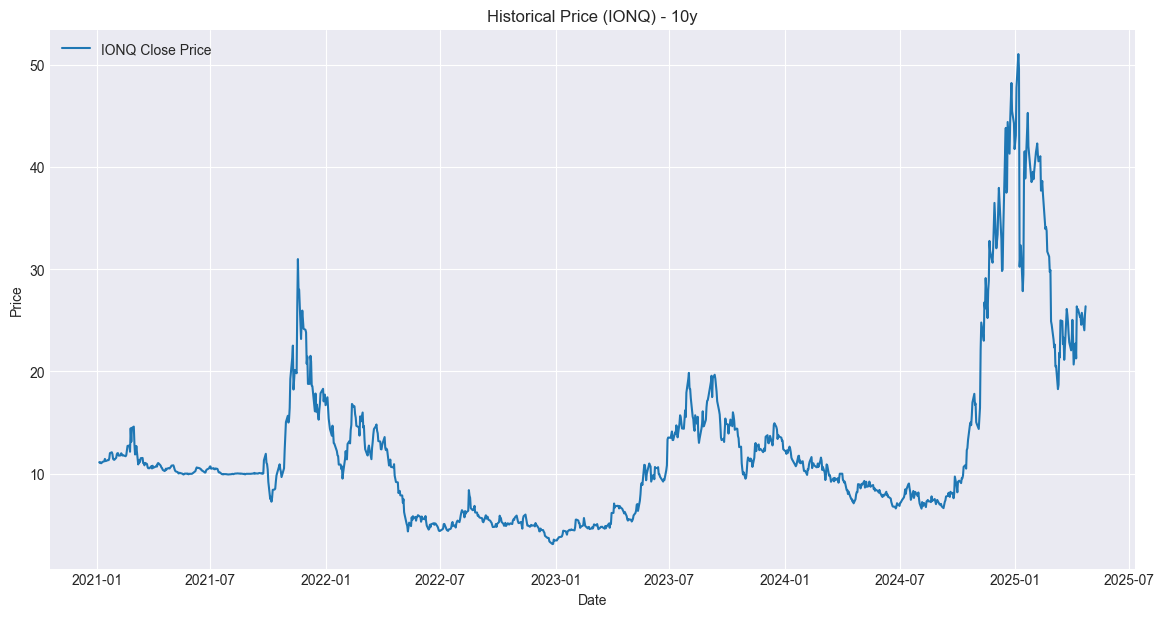

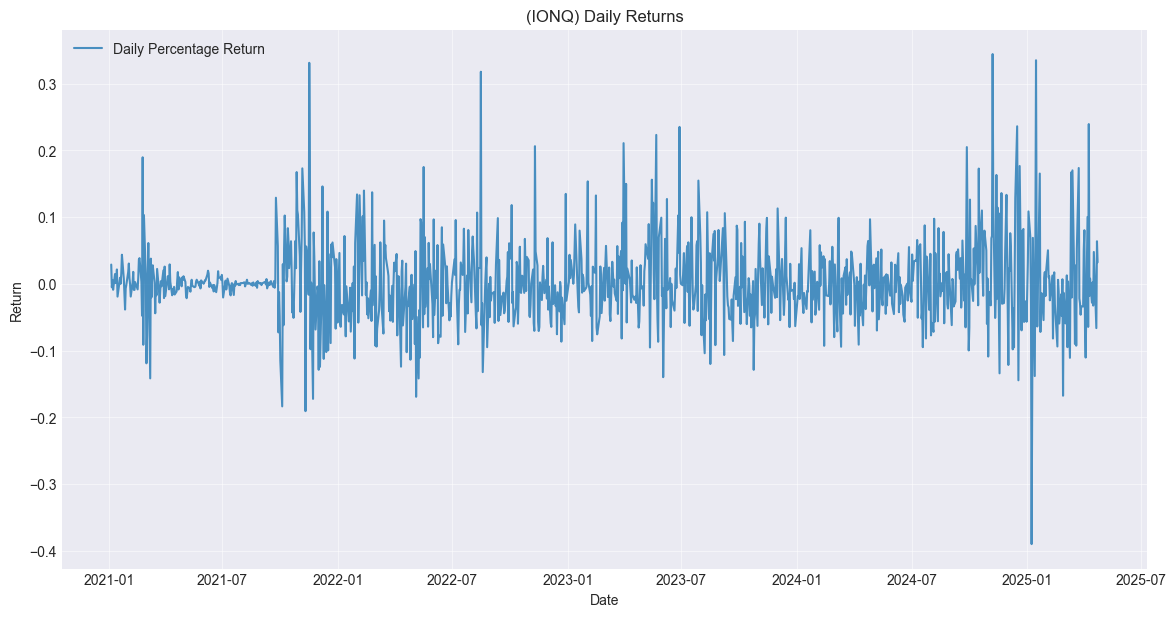

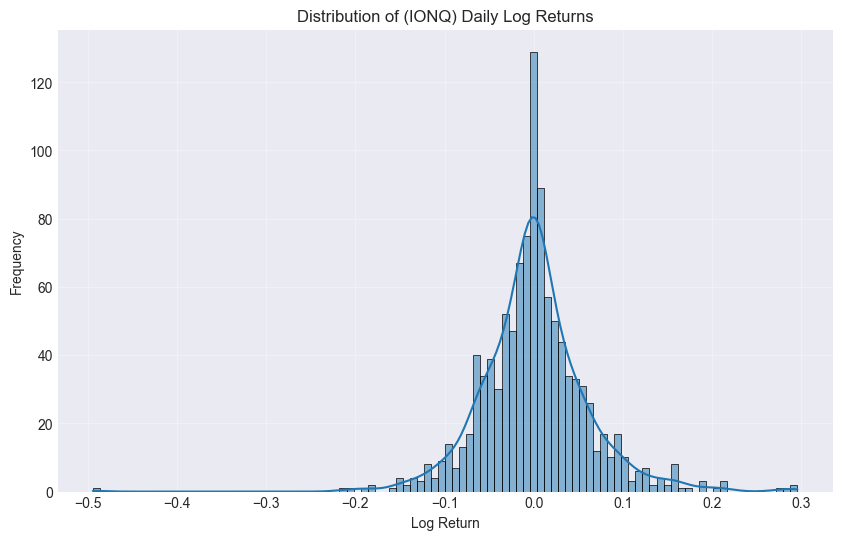

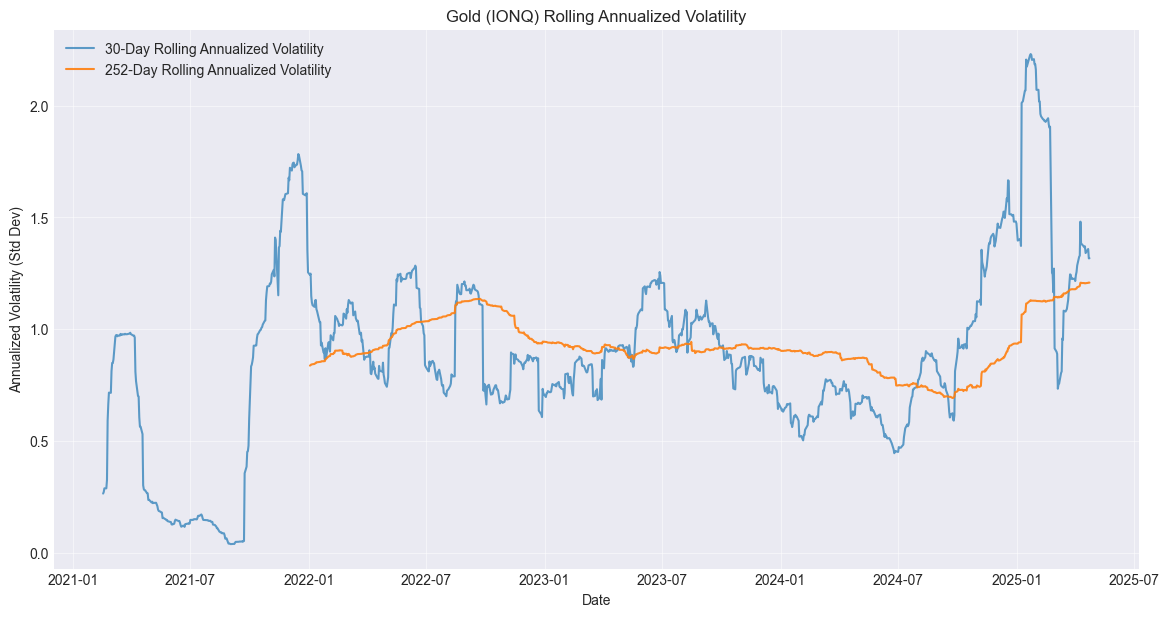

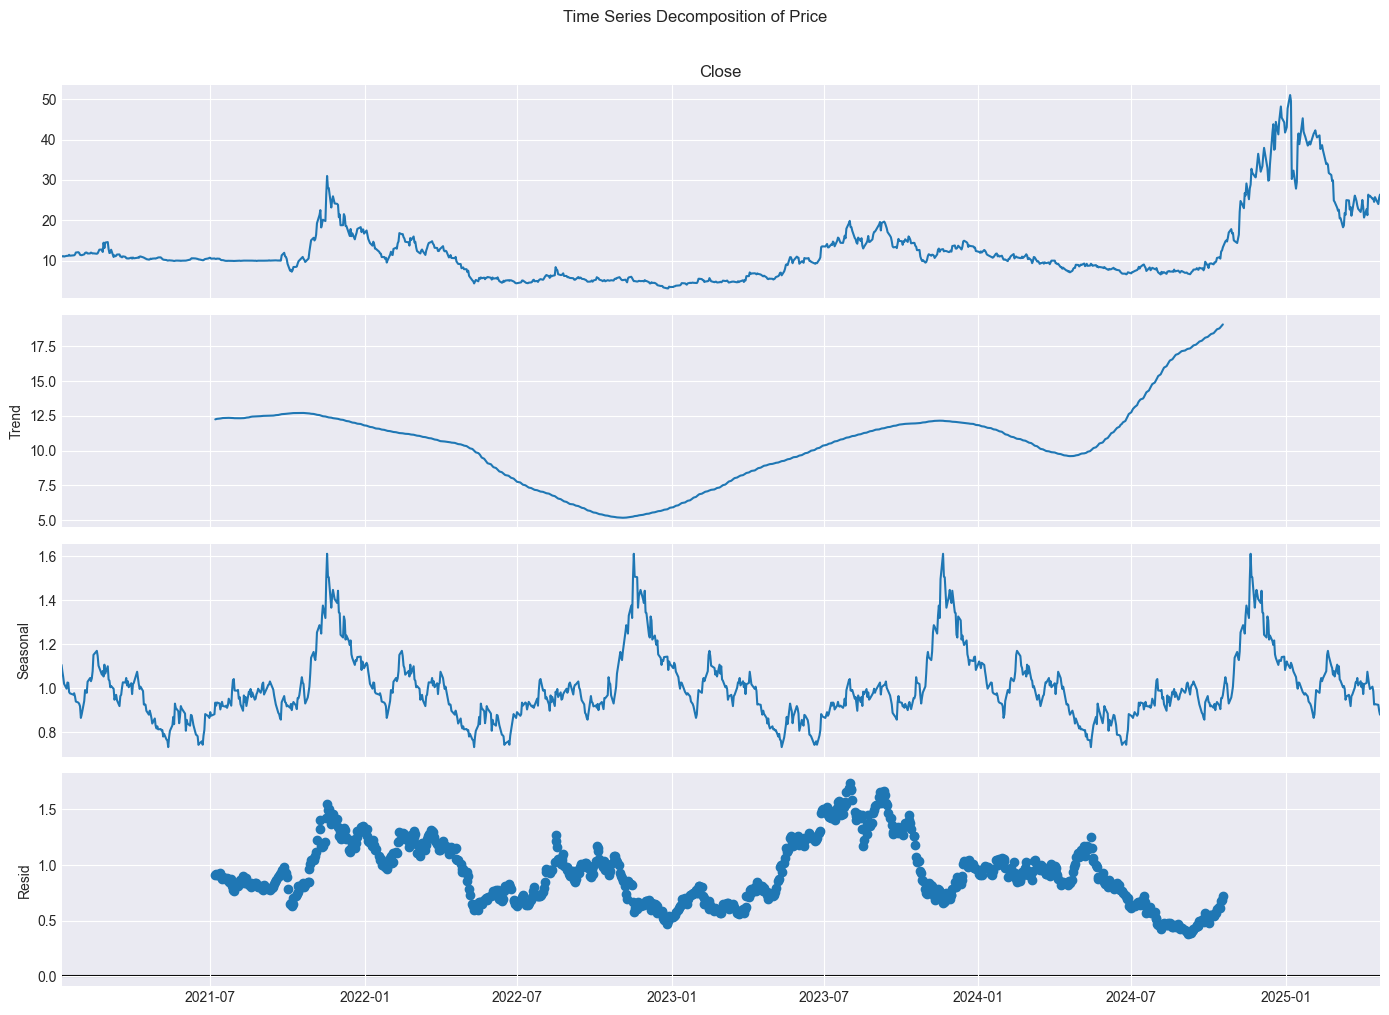

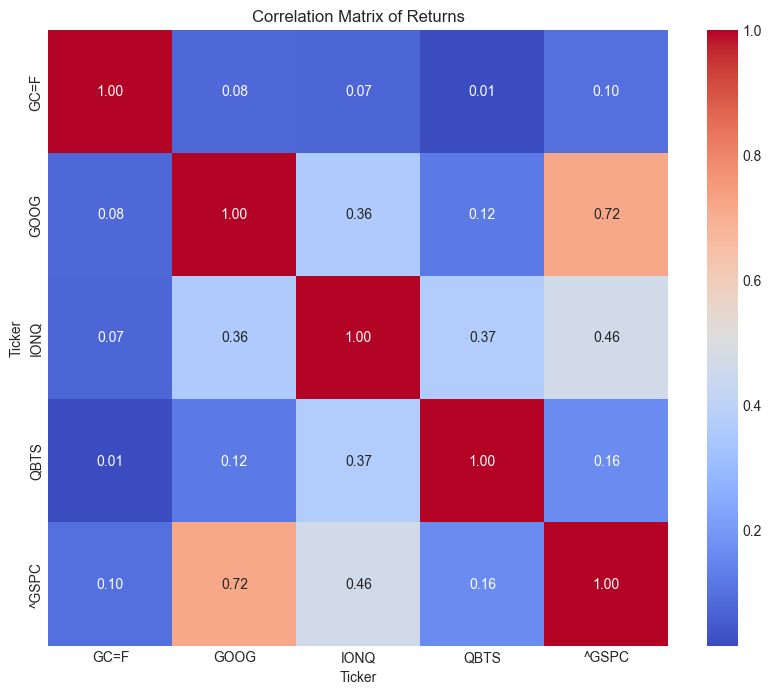

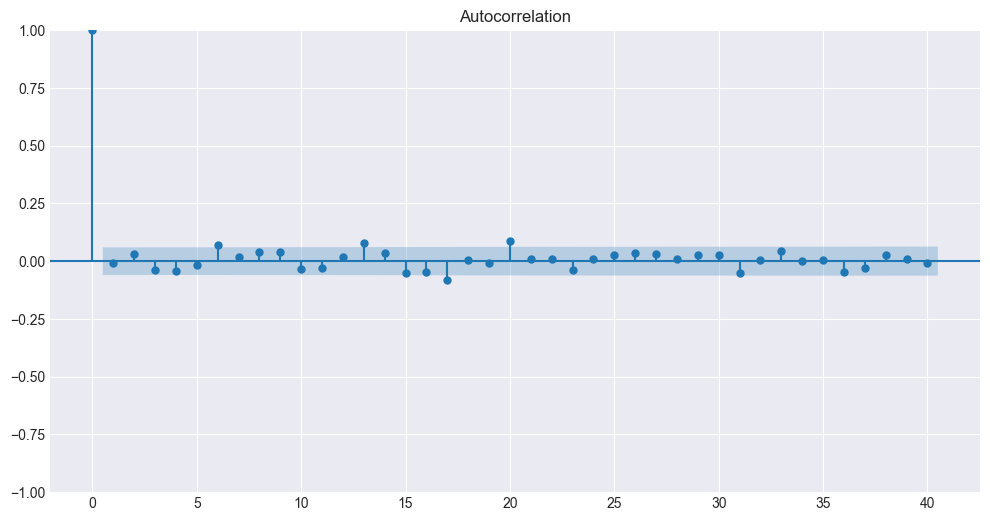

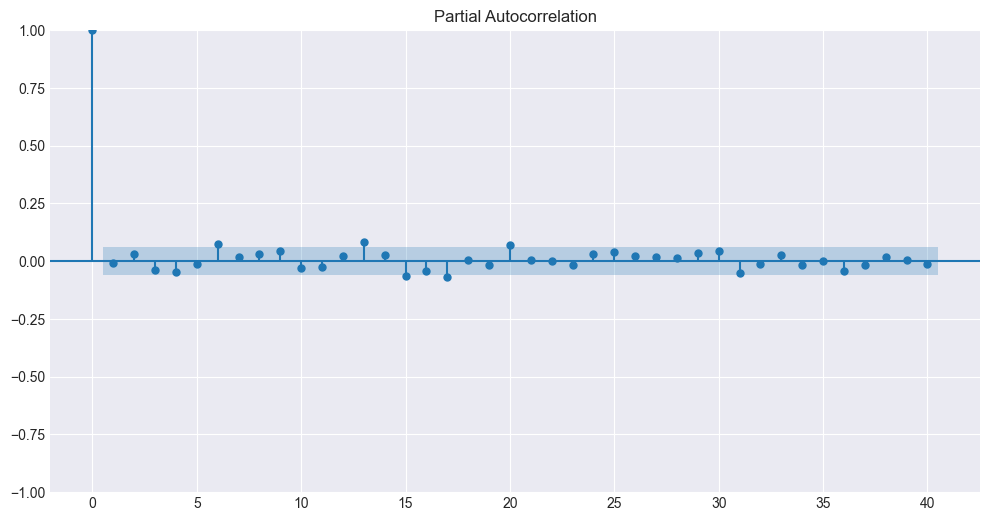

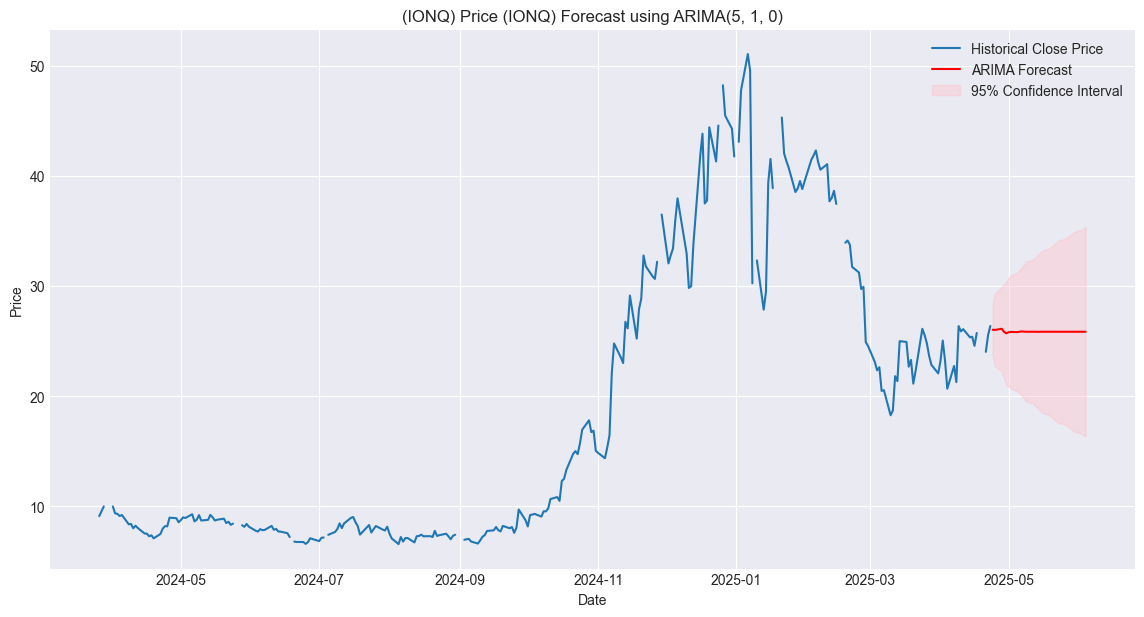

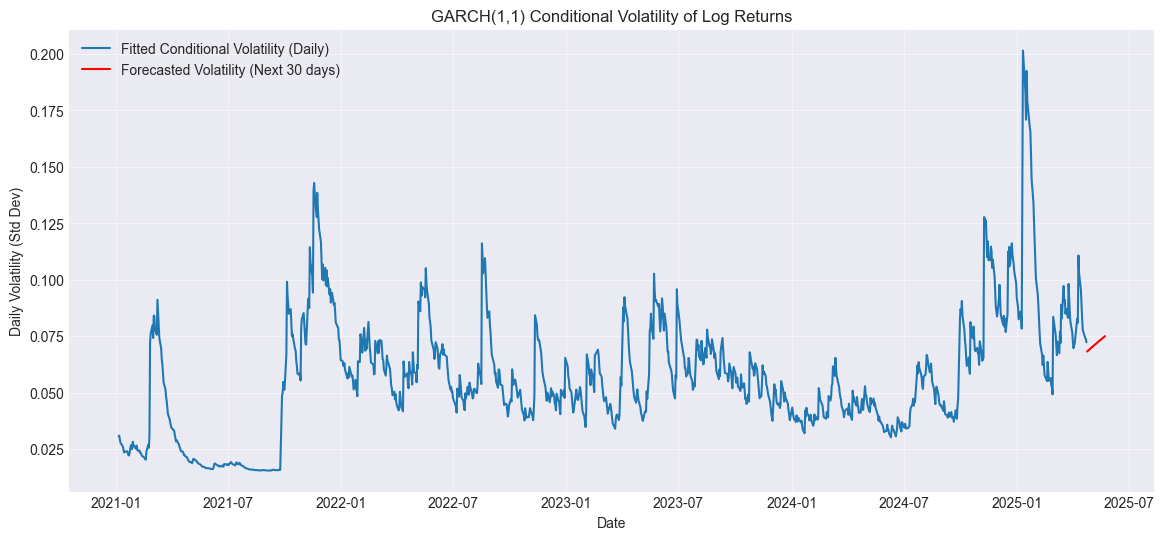


--- Model Performance Comparison (Lower is Better) ---
                        RMSE        MAE
Linear Regression   6.881249   4.851321
Random Forest      12.366757   8.749114
XGBoost            12.981167   9.276921
LSTM               13.491962   11.36577
SVR                15.028244  10.746405


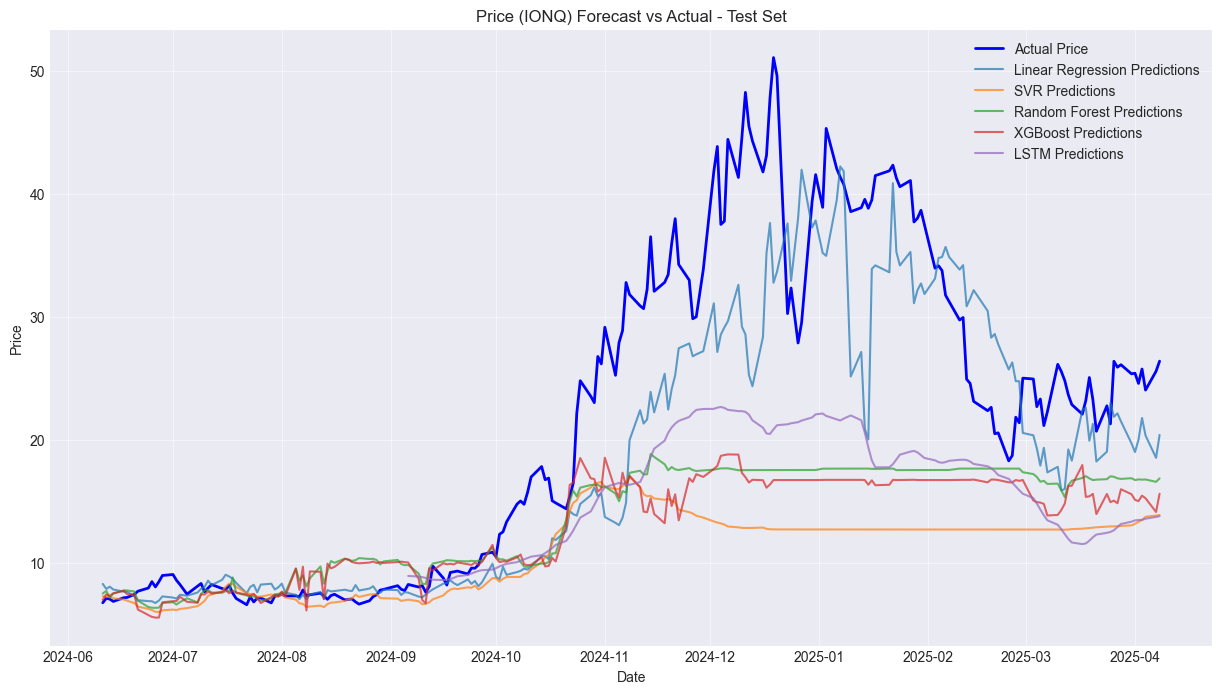

Plotting last 100 days for technical indicators.


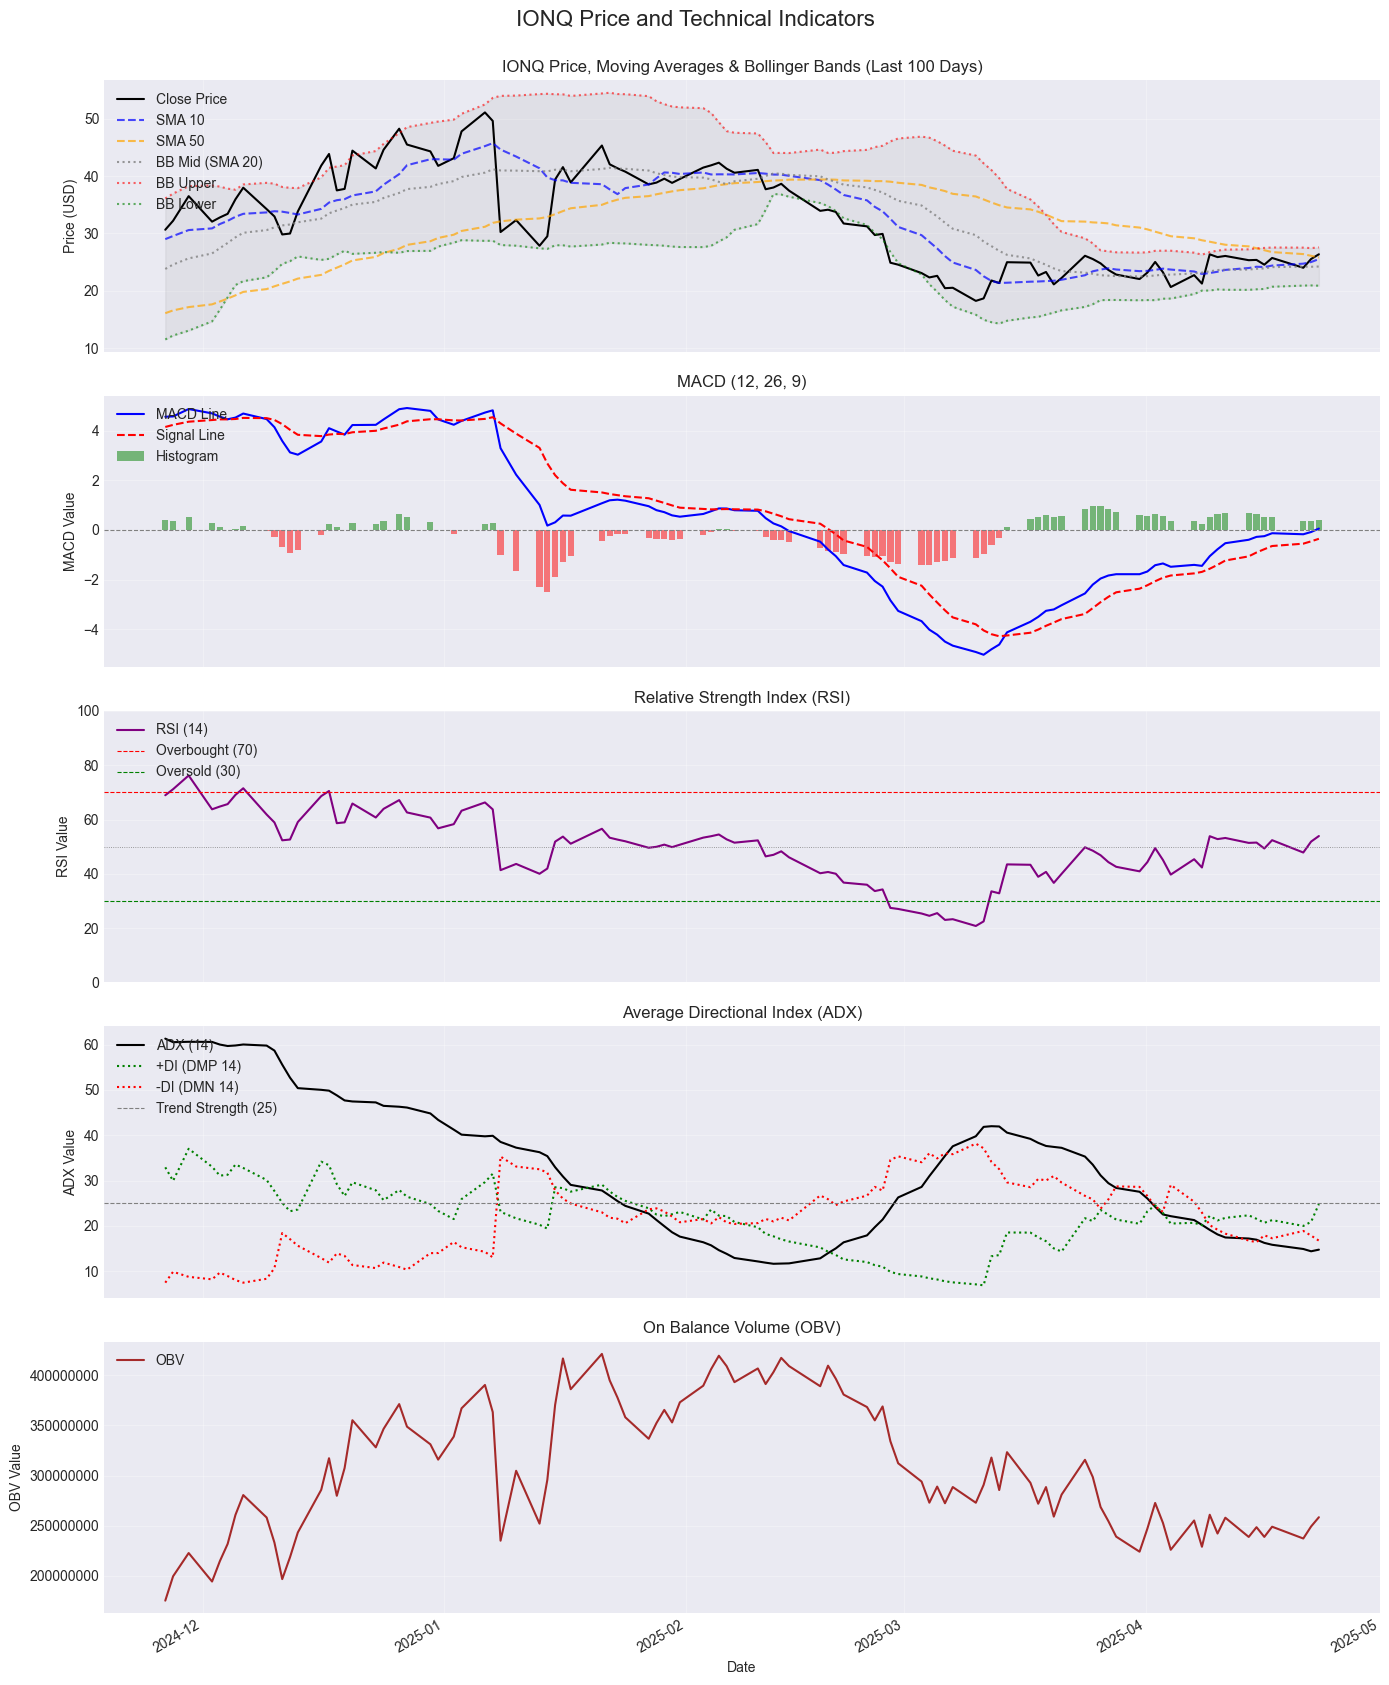

In [36]:
metrics_df

plt.figure(figsize=(14, 7))
plt.plot(gold_price['Close'], label=f'{ticker_symbol} Close Price')
plt.title(f'Historical Price ({ticker_symbol}) - {data_period}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(gold_price['Daily Return'], label='Daily Percentage Return', alpha=0.8)
plt.title(f'({ticker_symbol}) Daily Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(gold_price['Log Return'], bins=100, kde=True)
plt.title(f'Distribution of ({ticker_symbol}) Daily Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(gold_price['Rolling Volatility (30d)'], label=f'{rolling_window_short}-Day Rolling Annualized Volatility', alpha=0.7)
plt.plot(gold_price['Rolling Volatility (252d)'], label=f'{rolling_window_long}-Day Rolling Annualized Volatility', alpha=0.9)
plt.title(f'Gold ({ticker_symbol}) Rolling Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility (Std Dev)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

decomposition_period = 252 # Approx trading days in a year
if len(gold_price) > decomposition_period * 2: # Need at least 2 full periods
    result = seasonal_decompose(gold_price['Close'], model='multiplicative', period=decomposition_period)

    # Plot decomposition
    fig = result.plot()
    fig.set_size_inches(14, 10)
    fig.suptitle('Time Series Decomposition of Price', y=1.01)
    plt.tight_layout()
    plt.show()

    # Extract components
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid
else:
    print(f"Not enough data for decomposition with period {decomposition_period}. Need at least {decomposition_period * 2} data points.")
    trend, seasonal, residual = None, None, None # Assign None if decomposition not performed

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Returns')
plt.show()

plot_acf(gold_price['Log Return'].dropna(), lags=40)
plot_pacf(gold_price['Log Return'].dropna(), lags=40)
plt.show()

plt.figure(figsize=(14, 7))

# Plot historical data (show maybe last year + forecast period for clarity)
plot_start_date = gold_price_close.index[-252 - forecast_steps] # Approx 1 year before forecast start
plt.plot(gold_price_close[plot_start_date:], label='Historical Close Price')

# Plot the forecast mean
plt.plot(forecast_df['mean'], label='ARIMA Forecast', color='red')

# Plot the confidence intervals
plt.fill_between(forecast_df.index,
                 forecast_df['mean_ci_lower'],
                 forecast_df['mean_ci_upper'],
                 color='pink', alpha=0.4, label='95% Confidence Interval')

plt.title(f'({ticker_symbol}) Price ({ticker_symbol}) Forecast using ARIMA{order}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(garch_returns.index, garch_fit.conditional_volatility / 100, label='Fitted Conditional Volatility (Daily)') # Unscale
plt.plot(garch_forecast_index, forecast_volatility, label=f'Forecasted Volatility (Next {forecast_horizon_garch} days)', color='red')
plt.title('GARCH(1,1) Conditional Volatility of Log Returns')
plt.ylabel('Daily Volatility (Std Dev)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

results_df = pd.DataFrame(results).T[['RMSE', 'MAE']]
print("\n--- Model Performance Comparison (Lower is Better) ---")
print(results_df.sort_values(by='RMSE'))

# --- Plot Predictions vs Actual ---
plt.figure(figsize=(15, 8))
plt.plot(y_test.index, y_test, label='Actual Price', color='blue', linewidth=2)

# Plot predictions for each model
for name, result_data in results.items():
    if name == 'LSTM':
        # Adjust index for LSTM predictions
        plot_index = y_test_lstm_plotting.index
        plt.plot(plot_index, result_data['Predictions'], label=f'{name} Predictions', alpha=0.7)
    else:
        # Standard ML models align directly with y_test index
        plt.plot(y_test.index, result_data['Predictions'], label=f'{name} Predictions', alpha=0.7)


plt.title(f'Price ({ticker_symbol}) Forecast vs Actual - Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

if 'indicator_data' in locals():
    plot_data = indicator_data.copy()
    plot_data_subset = plot_data.iloc[-N_plot_days:] # N_plot_days is defined in your config cell (In[45])
    print(f"Plotting last {N_plot_days} days for technical indicators.")
else:
    print("Error: 'indicator_data' DataFrame not found. Cannot create plot_data_subset.")
    # Handle the error appropriately, maybe skip the indicator plot or raise an exception
    # For now, create an empty placeholder to avoid immediate error, but plots will fail:
    plot_data_subset = pd.DataFrame

plot_count = 3 # Start with Price/BB, MACD, RSI
optional_plots = []
if 'ADX_14' in plot_data_subset.columns: optional_plots.append('ADX')
if 'ATR_14' in plot_data_subset.columns: optional_plots.append('ATR')
if 'OBV' in plot_data_subset.columns: optional_plots.append('OBV')

plot_count += len(optional_plots)

fig, axes = plt.subplots(plot_count, 1, figsize=(14, plot_count * 3.5), sharex=True)
# Ensure axes is always a list, even if plot_count is 1
if plot_count == 1:
    axes = [axes]

current_ax_index = 0

# --- Plot 1: Price, Moving Averages, Bollinger Bands ---
ax = axes[current_ax_index]
ax.plot(plot_data_subset.index, plot_data_subset['Close'], label='Close Price', color='black', linewidth=1.5)

# Plot MAs if they exist
if 'SMA_10' in plot_data_subset.columns:
    ax.plot(plot_data_subset.index, plot_data_subset['SMA_10'], label='SMA 10', color='blue', linestyle='--', alpha=0.7)
if 'SMA_50' in plot_data_subset.columns:
    ax.plot(plot_data_subset.index, plot_data_subset['SMA_50'], label='SMA 50', color='orange', linestyle='--', alpha=0.7)

# Plot Bollinger Bands if they exist
if 'BBM_20_2.0' in plot_data_subset.columns: # Middle Band (usually SMA 20)
     ax.plot(plot_data_subset.index, plot_data_subset['BBM_20_2.0'], label='BB Mid (SMA 20)', color='grey', linestyle=':', alpha=0.8)
if all(c in plot_data_subset.columns for c in ['BBU_20_2.0', 'BBL_20_2.0']):
    ax.plot(plot_data_subset.index, plot_data_subset['BBU_20_2.0'], label='BB Upper', color='red', linestyle=':', alpha=0.6)
    ax.plot(plot_data_subset.index, plot_data_subset['BBL_20_2.0'], label='BB Lower', color='green', linestyle=':', alpha=0.6)
    # Fill between bands
    ax.fill_between(plot_data_subset.index, plot_data_subset['BBL_20_2.0'], plot_data_subset['BBU_20_2.0'], color='grey', alpha=0.1)

ax.set_ylabel('Price (USD)')
ax.set_title(f'{ticker_symbol} Price, Moving Averages & Bollinger Bands (Last {N_plot_days} Days)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
current_ax_index += 1


# --- Plot 2: MACD ---
ax = axes[current_ax_index]
if all(c in plot_data_subset.columns for c in ['MACD_12_26_9', 'MACDs_12_26_9', 'MACDh_12_26_9']):
    ax.plot(plot_data_subset.index, plot_data_subset['MACD_12_26_9'], label='MACD Line', color='blue')
    ax.plot(plot_data_subset.index, plot_data_subset['MACDs_12_26_9'], label='Signal Line', color='red', linestyle='--')
    # Plot MACD Histogram with colors
    colors = ['green' if val >= 0 else 'red' for val in plot_data_subset['MACDh_12_26_9']]
    ax.bar(plot_data_subset.index, plot_data_subset['MACDh_12_26_9'], label='Histogram', color=colors, alpha=0.5)
    ax.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Zero line
    ax.set_ylabel('MACD Value')
    ax.set_title('MACD (12, 26, 9)')
    ax.legend(loc='upper left')
else:
    ax.text(0.5, 0.5, 'MACD data not available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.grid(True, alpha=0.3)
current_ax_index += 1


# --- Plot 3: RSI ---
ax = axes[current_ax_index]
if 'RSI_14' in plot_data_subset.columns:
    ax.plot(plot_data_subset.index, plot_data_subset['RSI_14'], label='RSI (14)', color='purple')
    ax.axhline(70, color='red', linestyle='--', linewidth=0.8, label='Overbought (70)')
    ax.axhline(30, color='green', linestyle='--', linewidth=0.8, label='Oversold (30)')
    ax.axhline(50, color='grey', linestyle=':', linewidth=0.6) # Midpoint line
    ax.set_ylabel('RSI Value')
    ax.set_ylim(0, 100) # RSI ranges from 0 to 100
    ax.set_title('Relative Strength Index (RSI)')
    ax.legend(loc='upper left')
else:
    ax.text(0.5, 0.5, 'RSI data not available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.grid(True, alpha=0.3)
current_ax_index += 1


# --- Plot 4: ADX (Optional) ---
if 'ADX' in optional_plots:
    ax = axes[current_ax_index]
    if all(c in plot_data_subset.columns for c in ['ADX_14', 'DMP_14', 'DMN_14']):
        ax.plot(plot_data_subset.index, plot_data_subset['ADX_14'], label='ADX (14)', color='black')
        ax.plot(plot_data_subset.index, plot_data_subset['DMP_14'], label='+DI (DMP 14)', color='green', linestyle=':')
        ax.plot(plot_data_subset.index, plot_data_subset['DMN_14'], label='-DI (DMN 14)', color='red', linestyle=':')
        ax.axhline(25, color='grey', linestyle='--', linewidth=0.8, label='Trend Strength (25)') # Common threshold
        ax.set_ylabel('ADX Value')
        ax.set_title('Average Directional Index (ADX)')
        ax.legend(loc='upper left')
    else:
         ax.text(0.5, 0.5, 'ADX data not available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.grid(True, alpha=0.3)
    current_ax_index += 1


# --- Plot 5: ATR (Optional) ---
if 'ATR' in optional_plots:
    ax = axes[current_ax_index]
    if 'ATR_14' in plot_data_subset.columns:
        ax.plot(plot_data_subset.index, plot_data_subset['ATR_14'], label='ATR (14)', color='teal')
        ax.set_ylabel('ATR Value')
        ax.set_title('Average True Range (ATR) - Volatility')
        ax.legend(loc='upper left')
    else:
        ax.text(0.5, 0.5, 'ATR data not available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.grid(True, alpha=0.3)
    current_ax_index += 1


# --- Plot 6: OBV (Optional) ---
if 'OBV' in optional_plots:
    ax = axes[current_ax_index]
    if 'OBV' in plot_data_subset.columns:
        # OBV values can be large and not easily comparable, plot relative change or just the line
        ax.plot(plot_data_subset.index, plot_data_subset['OBV'], label='OBV', color='brown')
        # Use a secondary y-axis for OBV if its scale differs vastly from others? No, separate plot is fine.
        ax.set_ylabel('OBV Value')
        ax.set_title('On Balance Volume (OBV)')
        ax.legend(loc='upper left')
        # Turn off scientific notation on y-axis if numbers get large
        ax.ticklabel_format(style='plain', axis='y')
    else:
        ax.text(0.5, 0.5, 'OBV data not available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.grid(True, alpha=0.3)
    current_ax_index += 1


# --- Final Touches ---
# Improve date formatting on x-axis
for ax in axes:
     ax.xaxis.set_major_locator(mdates.MonthLocator(interval=max(1, N_plot_days // 252 * 2))) # Adjust interval based on plot duration
     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # Format as Year-Month

plt.xlabel('Date')
fig.autofmt_xdate() # Auto-rotate date labels
plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout to prevent title overlap, leave space for suptitle
fig.suptitle(f'{ticker_symbol} Price and Technical Indicators', fontsize=16, y=0.99) # Add overall title
plt.show()